In [16]:
import os
import pickle
from tabulate import tabulate

os.environ['OMP_NUM_THREADS'] = '4'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openai
openai.api_key = os.environ['OPENAI_API_KEY']
openai.api_base = os.environ.get("OPENAI_API_BASE", "https://api.openai.com/v1")
from data.serialize import SerializerSettings
from models.utils import grid_iter
from models.promptcast import get_promptcast_predictions_data
from models.darts import get_arima_predictions_data
from models.llmtime import get_llmtime_predictions_data
from data.small_context import get_datasets
from data.small_context import get_bitcoin_datasets
from data.small_context import get_bitcoin_datasets_hourly

from models.validation_likelihood_tuning import get_autotuned_predictions_data

%load_ext autoreload
%autoreload 2

def plot_preds(train, test, pred_dict, model_name, show_samples=False, save_index = 0):
    save_folder = "./plot/" + str(save_index)
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black')
    plt.plot(pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.savefig(save_folder)
    plt.show()


def plot_preds_candles(df, train, test, pred_dict, model_name, show_samples=False, save_index = 0):

    save_folder = "./plot/" + str(save_index)
    pred = pred_dict['median']
    pred = pd.Series(pred)
    index = len(train)

    opens = pd.Series(df['open'].values, index=df['date'])
    truth = pd.Series(df['close'].values, index=df['date'])
    highs = pd.Series(df['high'].values, index=df['date'])
    lows = pd.Series(df['low'].values, index=df['date'])

    plt.figure(figsize=(8, 6), dpi=100)

    ## Draw candles
    height = truth - opens
    bottom = np.where(height > 0, opens, truth + abs(height))
    color = np.where(height > 0, 'g', 'r')

    plt.bar(range(len(truth)), height, bottom=bottom, color=color, align='center')
    plt.vlines(range(len(highs)), ymin=lows, ymax=highs, color=color, linewidth=1)            

    plt.plot(range(index, index + len(pred)), pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(range(index, index + len(pred)), lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(range(index, index + len(pred)), samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

    index_to_display = range(0, len(truth), len(truth) // 6)
    truth.index = truth.index.date
    display_date = truth.index[index_to_display]
    plt.xticks(index_to_display, display_date)

    # plt.xticks(range(len(truth)), truth.index)
    # plt.grid()

    plt.savefig(save_folder)
    plt.show()


def plot_preds_candles_maxi(df, train, prediction, model_name , savefig = ""):

    save_folder = "./plot/" + savefig
    index = 0

    opens = pd.Series(df['open'].values, index=df['date'])
    truth = pd.Series(df['close'].values, index=df['date'])
    highs = pd.Series(df['high'].values, index=df['date'])
    lows = pd.Series(df['low'].values, index=df['date'])

    plt.figure(figsize=(8, 6), dpi=100)

    ## Draw candles
    height = truth - opens
    bottom = np.where(height > 0, opens, truth + abs(height))
    color = np.where(height > 0, 'g', 'r')

    plt.bar(range(len(truth)), height, bottom=bottom, color=color, align='center')
    plt.vlines(range(len(highs)), ymin=lows, ymax=highs, color=color, linewidth=1)      

    for pred in prediction :
        
        lower = np.quantile(pred, 0.05, axis=0)
        index_plus = len(lower) 
        upper = np.quantile(pred, 0.95, axis=0)
        
        plt.fill_between(range(index, index + index_plus), lower, upper, alpha=0.3, color='purple')

        medians = [sorted(sublist)[len(sublist)//2] if len(sublist) % 2 != 0 else
                (sorted(sublist)[len(sublist)//2 - 1] + sorted(sublist)[len(sublist)//2]) / 2
                for sublist in zip(*pred)]  

        plt.plot(range(index, index + index_plus), medians, color='purple')
        index += index_plus 
        index -= 1


    # plt.plot(range(index, index + len(pred[0])), pred[0], label=model_name, color='purple')
    plt.legend(loc='upper left')
    plt.title(model_name)


    index_to_display = range(0, len(truth), len(truth) // 6)
    truth.index = truth.index.date
    display_date = truth.index[index_to_display]
    plt.xticks(index_to_display, display_date)

    # plt.xticks(range(len(truth)), truth.index)

    plt.savefig(save_folder)
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define models ##

In [3]:
gpt4_hypers = dict(
    alpha=0.3,
    basic=True,
    temp=1.0,
    top_p=0.8,
    settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=', ', bit_sep='', minus_sign='-')
)

gpt3_hypers = dict(
    temp=0.7,
    alpha=0.95,
    beta=0.3,
    basic=False,
    settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
)


promptcast_hypers = dict(
    temp=0.7,
    settings=SerializerSettings(base=10, prec=0, signed=True, 
                                time_sep=', ',
                                bit_sep='',
                                plus_sign='',
                                minus_sign='-',
                                half_bin_correction=False,
                                decimal_point='')
)

arima_hypers = dict(p=[12,30], d=[1,2], q=[0])

model_hypers = {
    'LLMTime GPT-3.5': {'model': 'gpt-3.5-turbo-instruct', **gpt3_hypers},
    'LLMTime GPT-4': {'model': 'gpt-4', **gpt4_hypers},
    # 'LLMTime GPT-3': {'model': 'text-davinci-004', **gpt3_hypers},
    # 'PromptCast GPT-3': {'model': 'text-davinci-004', **promptcast_hypers},
    # 'ARIMA': arima_hypers,
    
}

model_predict_fns = {
    # 'LLMTime GPT-3.5': get_llmtime_predictions_data,
    # 'LLMTime GPT-3': get_llmtime_predictions_data,
    'LLMTime GPT-4': get_llmtime_predictions_data,
    # 'PromptCast GPT-3': get_promptcast_predictions_data,
    # 'ARIMA': get_arima_predictions_data,
}

model_names = list(model_predict_fns.keys())

In [4]:
starting_date = '2023-11-01'
index = 0
for predict_step in [3,5,7] :

    with open(f"datasets/bitcoin/BTC_BitHourly.csv") as f:
        df = pd.read_csv(f, usecols=[0, 5], parse_dates=[0])
        mask = (df["timestamp"] > starting_date) 
        df = df.loc[mask]

        start_date = df["timestamp"].iloc[0]
        end_date = df["timestamp"].iloc[-1]

        print("Data set : BTC_Daily_ohlc")
        print(f"from {start_date} to {end_date}")
        print(f"{df.shape[0]} data points, training on {df.shape[0]- predict_step} and forecasting on {predict_step} points")
        print("Imput is scaled closing price")

    datasets = get_bitcoin_datasets_hourly(predict_steps=predict_step, timestamp="2023-11-01")
    ds_name = 'BTC_BitHourly'


    data = datasets[ds_name]
    train, test = data # or change to your own data
    print(train)

Data set : BTC_Daily_ohlc
from 2023-11-01 01:00:00 to 2023-11-29 10:00:00
682 data points, training on 610 and forecasting on 72 points
Imput is scaled closing price
timestamp
2023-11-01 01:00:00    34439.0
2023-11-01 02:00:00    34392.0
2023-11-01 03:00:00    34487.0
2023-11-01 04:00:00    34553.0
2023-11-01 05:00:00    34652.0
                        ...   
2023-11-26 06:00:00    37823.0
2023-11-26 07:00:00    37757.0
2023-11-26 08:00:00    37809.0
2023-11-26 09:00:00    37764.0
2023-11-26 10:00:00    37710.0
Length: 610, dtype: float64
Data set : BTC_Daily_ohlc
from 2023-11-01 01:00:00 to 2023-11-29 10:00:00
682 data points, training on 562 and forecasting on 120 points
Imput is scaled closing price
timestamp
2023-11-01 01:00:00    34439.0
2023-11-01 02:00:00    34392.0
2023-11-01 03:00:00    34487.0
2023-11-01 04:00:00    34553.0
2023-11-01 05:00:00    34652.0
                        ...   
2023-11-24 06:00:00    37257.0
2023-11-24 07:00:00    37309.0
2023-11-24 08:00:00    37301.0

Data set : BTC_Daily_ohlc
from 2023-11-17 to 2023-01-01
training on 6 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

pred dict {'samples': date  2023-11-23 09:00:00  2023-11-24 09:00:00  2023-11-25 09:00:00  \
0            38329.746131         35695.147828         38366.337774   
1            37451.546697         34816.948394         38476.112703   
2            38256.562844         34597.398536         38988.395706   
3            37488.138340         34853.540038         37524.729983   
4            37451.546697         34853.540038         37378.363410   
5            37488.138340         34853.540038         37524.729983   
6            37378.363410         34853.540038         37341.771767   
7            37488.138340         34853.540038         37524.729983   
8            38659.070918         38622.479275         39427.495423   
9            35731.739472         37488.138340         35731.739472   

date  2023-11-26 09:00:00  2023-11-27 09:00:00  2023-11-28 09:00:00  \
0            39281.128851         39281.128851         39281.128851   
1            38476.112703         38476.112703        

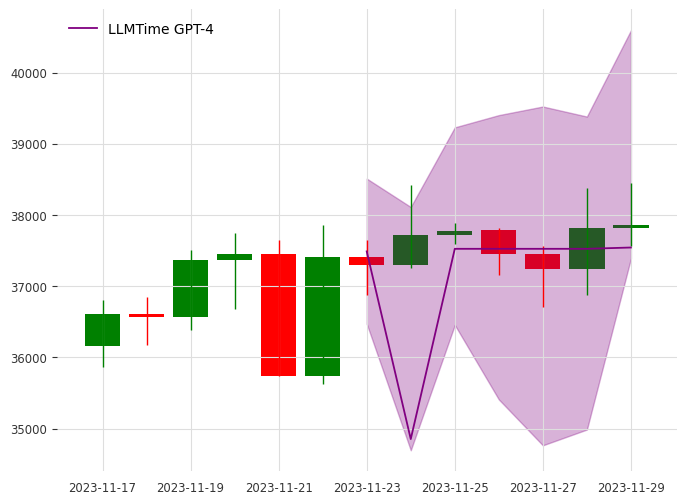

Data set : BTC_Daily_ohlc
from 2023-11-11 to 2023-01-01
training on 12 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

pred dict {'samples': date  2023-11-23 09:00:00  2023-11-24 09:00:00  2023-11-25 09:00:00  \
0            36258.164093         36331.154861         36550.127166   
1            36732.604086         37280.034848         36842.090238   
2            36623.117934         35637.742563         37280.034848   
3            37280.034848         36440.641013         35820.219484   
4            36951.576391         36696.108702         35966.201020   
5            35820.219484         36002.696404         35418.770259   
6            37900.456377         37389.521000         37243.539463   
7            35820.219484         36659.613318         36915.081007   
8            36258.164093         36988.071775         37535.502536   
9            36805.594854         36696.108702         36112.182557   

date  2023-11-26 09:00:00  2023-11-27 09:00:00  2023-11-28 09:00:00  \
0            36258.164093         37170.548695         36148.677941   
1            37571.997920         37608.493304        

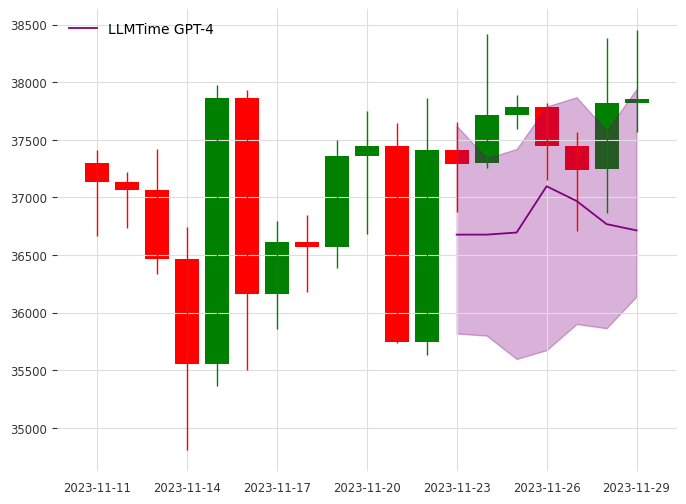

Data set : BTC_Daily_ohlc
from 2023-10-30 to 2023-01-01
training on 24 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

pred dict {'samples': date  2023-11-23 09:00:00  2023-11-24 09:00:00  2023-11-25 09:00:00  \
0            37328.923250         38213.075861         38319.174175   
1            37258.191041         37505.753772         38920.397950   
2            37505.753772         37576.485981         37682.584294   
3            37116.726623         37505.753772         37222.824937   
4            37152.092728         37541.119877         37647.218190   
5            36798.431683         37930.147026         38496.004697   
6            35843.546863         35985.011281         36091.109594   
7            37894.780921         37824.048712         38248.441966   
8            36904.529997         37152.092728         36798.431683   
9            36939.896101         37045.994414         37576.485981   

date  2023-11-26 09:00:00  2023-11-27 09:00:00  2023-11-28 09:00:00  \
0            37576.485981         37470.387668         37753.316503   
1            39097.228473         38743.567428        

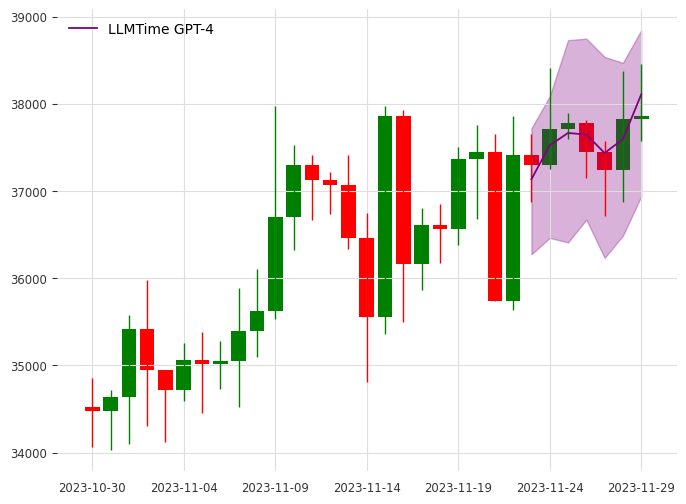

Data set : BTC_Daily_ohlc
from 2023-10-06 to 2023-01-01
training on 48 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

pred dict {'samples': date  2023-11-23 09:00:00  2023-11-24 09:00:00  2023-11-25 09:00:00  \
0            36894.710422         36835.322558         38023.079835   
1            37191.649741         37607.364788         37251.037605   
2            37340.119401         37280.731537         37369.813332   
3            37221.343673         37340.119401         37458.895128   
4            37607.364788         37696.446584         37785.528379   
5            37637.058720         38320.019154         38706.040269   
6            37280.731537         37844.916243         38498.182746   
7            37369.813332         35766.341008         35499.095621   
8            37310.425469         37904.304107         38379.407018   
9            37429.201196         37518.282992         36894.710422   

date  2023-11-26 09:00:00  2023-11-27 09:00:00  2023-11-28 09:00:00  \
0            37191.649741         37221.343673         37399.507264   
1            36508.689307         36746.240762        

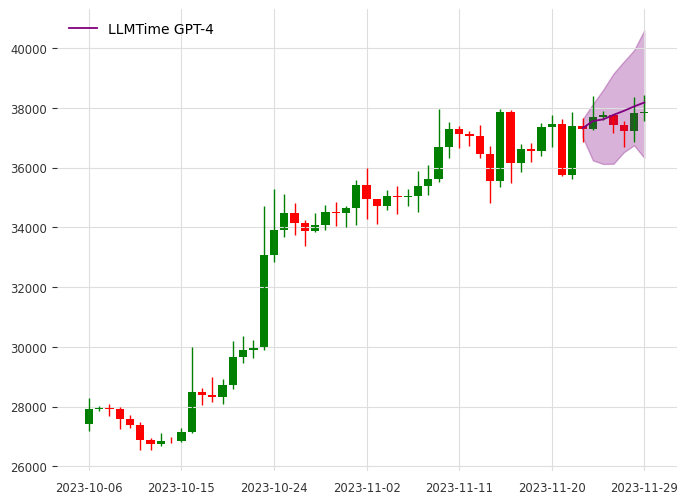

Data set : BTC_Daily_ohlc
from 2023-08-19 to 2023-01-01
training on 96 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

pred dict {'samples': date  2023-11-23 09:00:00  2023-11-24 09:00:00  2023-11-25 09:00:00  \
0            37997.673780         37918.097499         37891.572073   
1            36989.707564         36379.622750         37546.741525   
2            37626.317806         38130.300913         38050.724633   
3            37493.690672         37997.673780         38554.707741   
4            37599.792379         37811.995793         38315.978900   
5            37493.690672         36750.978724         35981.741349   
6            37865.046646         37732.419512         38236.402620   
7            37467.165245         37705.894086         37758.944939   
8            37918.097499         38369.029754         38289.453474   
9            37599.792379         37705.894086         37865.046646   

date  2023-11-26 09:00:00  2023-11-27 09:00:00  2023-11-28 09:00:00  \
0            37573.266952         37361.063538         36857.080431   
1            38156.826340         37865.046646        

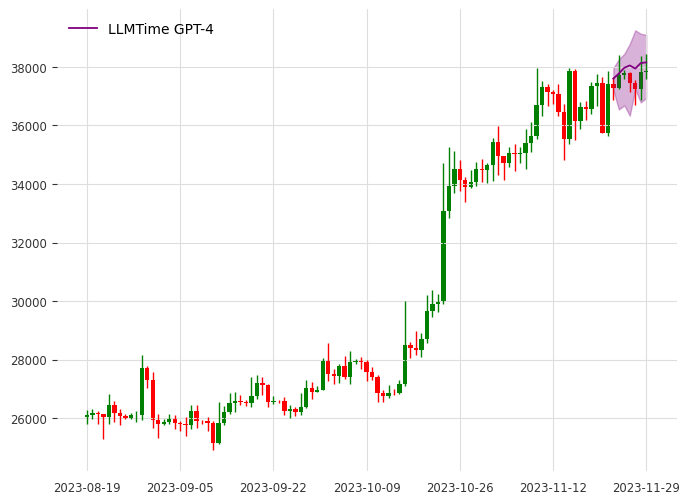

Data set : BTC_Daily_ohlc
from 2023-05-15 to 2023-01-01
training on 192 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

pred dict {'samples': date  2023-11-23 09:00:00  2023-11-24 09:00:00  2023-11-25 09:00:00  \
0            37384.926198         37062.989267         36687.396179   
1            37304.441965         37358.098121         37706.863130   
2            37331.270043         37411.754276         37653.206975   
3            37223.957732         37304.441965         37250.785810   
4            37170.301577         37331.270043         37170.301577   
5            37277.613888         35855.725772         34621.634201   
6            37089.817344         37009.333111         37438.582354   
7            36338.631170         36741.052335         36499.599636   
8            36982.505034         36928.848878         37116.645422   
9            37358.098121         37277.613888         37250.785810   

date  2023-11-26 09:00:00  2023-11-27 09:00:00  2023-11-28 09:00:00  \
0            36445.943481         36606.911947         36338.631170   
1            38431.221226         38189.768528        

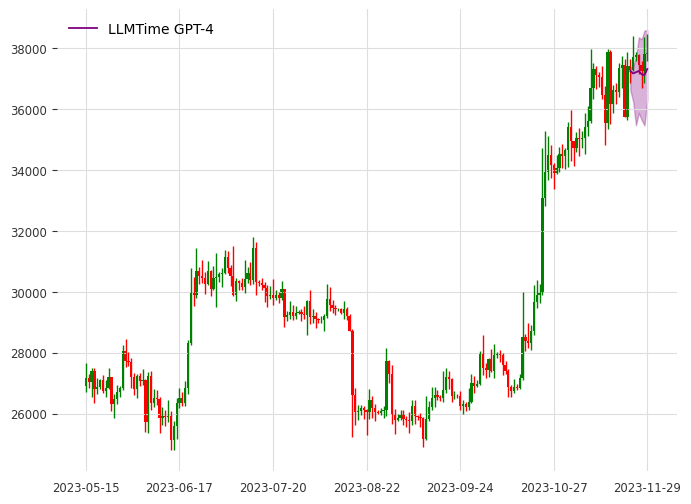

Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only
The path for the pickle file are the following : 
pickle/dic_error_classic_2023-11-30_median.pkl
Data set : BTC_Daily_ohlc
from 2023-11-23 to 2023-01-01
training on 6 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

pred dict {'samples': date  2023-11-29 09:00:00  2023-11-30 09:00:00  2023-12-01 09:00:00  \
0            37688.919568         37913.147151         37389.949457   
1            37875.775887         37576.805776         37352.578193   
2            37875.775887         37576.805776         37352.578193   
3            37875.775887         37576.805776         37352.578193   
4            37875.775887         37576.805776         37352.578193   
5            37875.775887         37576.805776         37352.578193   
6            37875.775887         37576.805776         37352.578193   
7            37913.147151         37688.919568         37389.949457   
8            37875.775887         37576.805776         37352.578193   
9            37987.889678         37688.919568         37389.949457   

date  2023-12-02 09:00:00  2023-12-03 09:00:00  2023-12-04 09:00:00  \
0            37614.177040         37651.548304         37651.548304   
1            37950.518415         37987.889678        

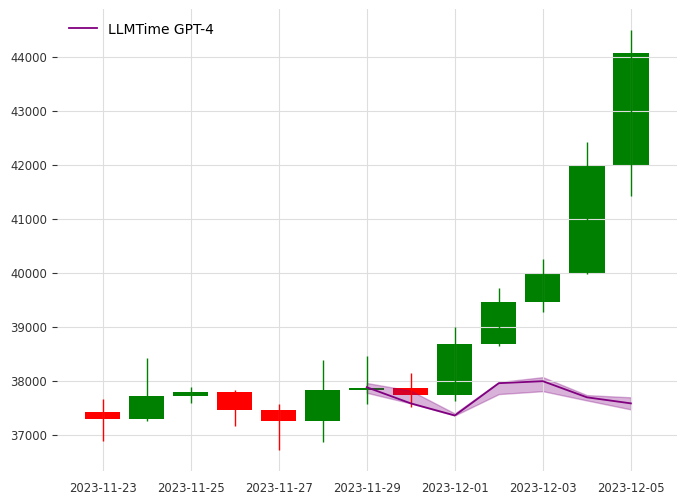

Data set : BTC_Daily_ohlc
from 2023-11-17 to 2023-01-01
training on 12 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

pred dict {'samples': date  2023-11-29 09:00:00  2023-11-30 09:00:00  2023-12-01 09:00:00  \
0            37053.249230         37910.187120         37090.507399   
1            37984.703459         37649.379936         36978.732891   
2            37686.638105         36606.151200         37872.928951   
3            37537.605429         38133.736135         38208.252474   
4            37984.703459         38059.219797         38096.477966   
5            37761.154444         38170.994305         38245.510643   
6            37761.154444         38208.252474         38282.768812   
7            37165.023737         37947.445290         38021.961628   
8            37537.605429         38021.961628         38096.477966   
9            37910.187120         37947.445290         37574.863598   

date  2023-12-02 09:00:00  2023-12-03 09:00:00  2023-12-04 09:00:00  \
0            37947.445290         37127.765568         37984.703459   
1            38021.961628         38170.994305        

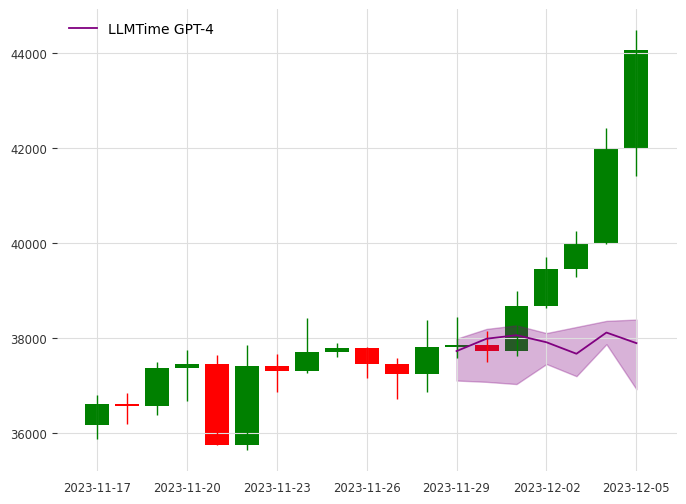

Data set : BTC_Daily_ohlc
from 2023-11-05 to 2023-01-01
training on 24 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]

pred dict {'samples': date  2023-11-29 09:00:00  2023-11-30 09:00:00  2023-12-01 09:00:00  \
0            37326.498536         37508.667880         37362.932405   
1            37508.667880         37909.440436         37581.535617   
2            37362.932405         37435.800142         37800.138830   
3            37362.932405         37180.763061         37144.329192   
4            37290.064667         37617.969486         37727.271092   
5            37326.498536         37545.101749         37982.308174   
6            37326.498536         37180.763061         37581.535617   
7            37545.101749         37763.704961         37435.800142   
8            37800.138830         37508.667880         37581.535617   
9            37581.535617         37763.704961         37873.006567   

date  2023-12-02 09:00:00  2023-12-03 09:00:00  2023-12-04 09:00:00  \
0            36524.953424         35541.238967         37617.969486   
1            37472.234011         37982.308174        

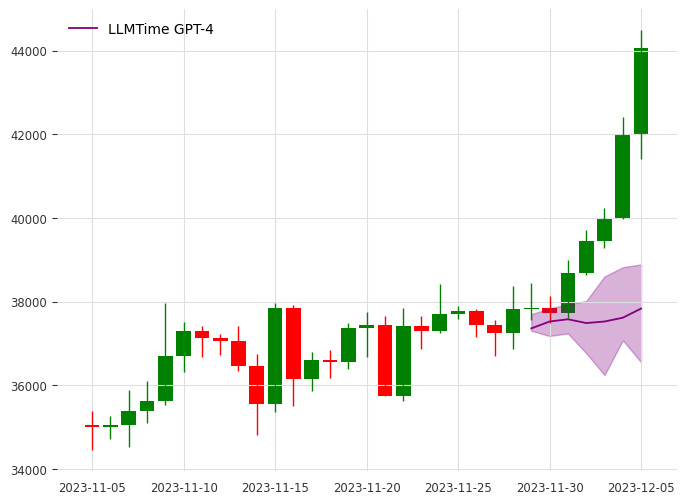

Data set : BTC_Daily_ohlc
from 2023-10-12 to 2023-01-01
training on 48 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

pred dict {'samples': date  2023-11-29 09:00:00  2023-11-30 09:00:00  2023-12-01 09:00:00  \
0            37684.865822         38059.839612         38093.928138   
1            37753.042875         37957.574033         37991.662559   
2            37923.485507         38162.105191         38332.547822   
3            37684.865822         37753.042875         37718.954349   
4            37378.069086         37514.423191         37718.954349   
5            37753.042875         37889.396980         38093.928138   
6            37787.131401         37957.574033         38741.610138   
7            37684.865822         37855.308454         38196.193717   
8            37718.954349         38128.016664         37855.308454   
9            37718.954349         37753.042875         38059.839612   

date  2023-12-02 09:00:00  2023-12-03 09:00:00  2023-12-04 09:00:00  \
0            38196.193717         38230.282243         38332.547822   
1            38400.724875         38639.344559        

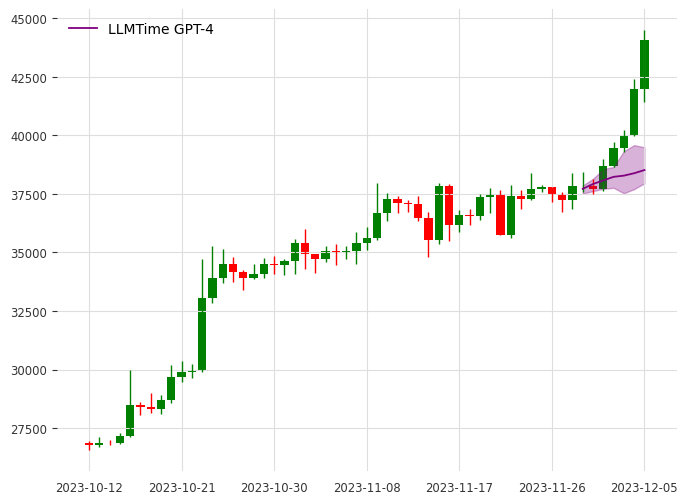

Data set : BTC_Daily_ohlc
from 2023-08-25 to 2023-01-01
training on 96 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

pred dict {'samples': date  2023-11-29 09:00:00  2023-11-30 09:00:00  2023-12-01 09:00:00  \
0            37818.771889         37898.811618         37765.412070   
1            37845.451799         37898.811618         37978.851347   
2            37765.412070         37978.851347         37898.811618   
3            38032.211166         37391.893335         38432.409810   
4            37765.412070         37978.851347         38218.970533   
5            37658.692431         37632.012522         38165.610714   
6            37738.732160         37765.412070         38058.891076   
7            38005.531256         38218.970533         38138.930804   
8            37765.412070         37365.213425         37311.853606   
9            37765.412070         37685.372341         37658.692431   

date  2023-12-02 09:00:00  2023-12-03 09:00:00  2023-12-04 09:00:00  \
0            37685.372341         37818.771889         37845.451799   
1            38032.211166         38112.250895        

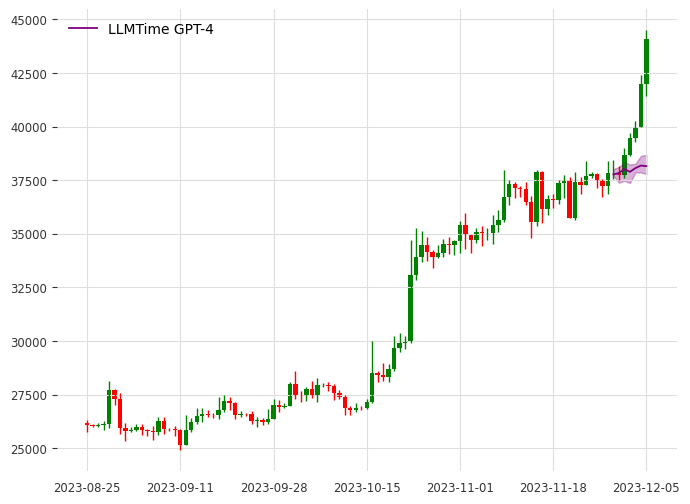

Data set : BTC_Daily_ohlc
from 2023-05-21 to 2023-01-01
training on 192 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


pred dict {'samples': date  2023-11-29 09:00:00  2023-11-30 09:00:00  2023-12-01 09:00:00  \
0            37409.660790         37758.656549         37651.273238   
1            37678.119066         38000.268997         38080.806480   
2            37517.044100         37302.277479         37168.048341   
3            37651.273238         37758.656549         37436.506617   
4            37651.273238         37919.731514         38080.806480   
5            37785.502376         37463.352445         37651.273238   
6            37543.889928         37678.119066         38215.035618   
7            37866.039859         38027.114825         37973.423170   
8            37651.273238         37409.660790         37302.277479   
9            37704.964893         37329.123307         36899.590065   

date  2023-12-02 09:00:00  2023-12-03 09:00:00  2023-12-04 09:00:00  \
0            37812.348204         38322.418929         38429.802239   
1            38215.035618         38698.260515        

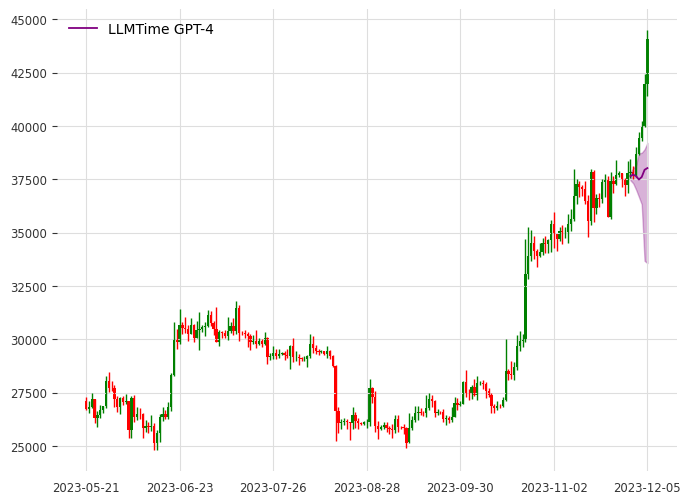

Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only
The path for the pickle file are the following : 
pickle/dic_error_classic_2023-12-06_median.pkl
Data set : BTC_Daily_ohlc
from 2023-11-29 to 2023-01-01
training on 6 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

pred dict {'samples': date  2023-12-05 09:00:00  2023-12-06 09:00:00  2023-12-07 09:00:00  \
0            43454.681171         44794.103312         46707.563513   
1            43990.450027         45942.179432         48085.254858   
2            43837.373211         45865.641024         48085.254858   
3            42918.912314         44258.334455         45482.948984   
4            43913.911619         45750.833412         47779.101226   
5            43760.834803         45789.102616         47626.024409   
6            44334.872863         46937.178737         49730.830631   
7            43225.065947         44641.026495         46248.333065   
8            42574.489478         44220.065251         44220.065251   
9            44028.719231         46210.063861         46210.063861   

date  2023-12-08 09:00:00  2023-12-09 09:00:00  2023-12-10 09:00:00  \
0            48544.485306         48544.485306         48544.485306   
1            50381.407099         52601.020933        

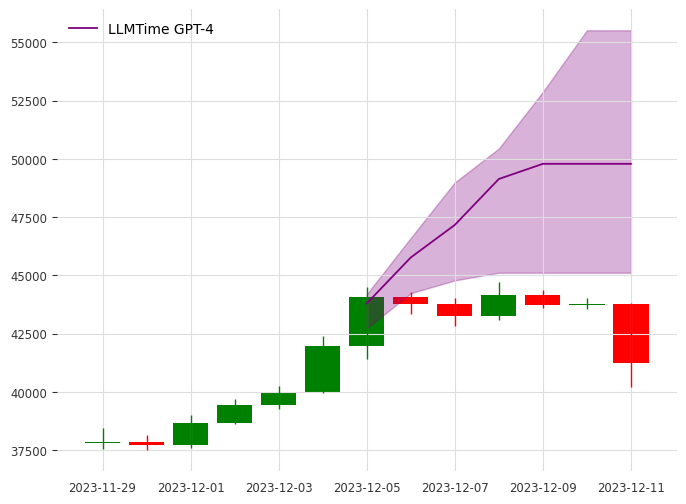

Data set : BTC_Daily_ohlc
from 2023-11-23 to 2023-01-01
training on 12 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]

pred dict {'samples': date  2023-12-05 09:00:00  2023-12-06 09:00:00  2023-12-07 09:00:00  \
0            42300.171907         42790.499356         43393.979294   
1            42187.019418         42601.911876         42677.346868   
2            43129.956821         44148.329217         45091.266620   
3            43808.871752         45393.006589         47128.011411   
4            42073.866930         42601.911876         42828.216852   
5            42036.149434         42073.866930         42149.301922   
6            43054.521829         44186.046713         45996.486527   
7            42224.736914         43318.544302         44714.091659   
8            42224.736914         42601.911876         43733.436759   
9            42941.369341         43997.459232         45128.984116   

date  2023-12-08 09:00:00  2023-12-09 09:00:00  2023-12-10 09:00:00  \
0            44186.046713         45166.701612         46335.943992   
1            42337.889403         42149.301922        

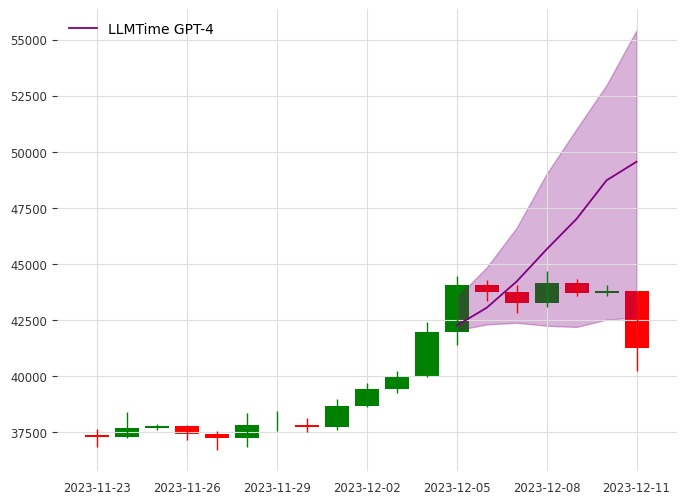

Data set : BTC_Daily_ohlc
from 2023-11-11 to 2023-01-01
training on 24 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  2.00s/it]

pred dict {'samples': date  2023-12-05 09:00:00  2023-12-06 09:00:00  2023-12-07 09:00:00  \
0            43119.702027         45161.530363         46980.613789   
1            42599.963906         43379.571088         44196.302422   
2            42043.101632         42265.846542         42599.963906   
3            43490.943543         45161.530363         47017.737940   
4            43156.826179         44493.295635         45681.268484   
5            43416.695240         44678.916393         46460.875667   
6            42191.598239         42674.212209         43268.198634   
7            42191.598239         42488.591451         43082.577876   
8            43119.702027         44047.805816         45161.530363   
9            43416.695240         45310.026969         47017.737940   

date  2023-12-08 09:00:00  2023-12-09 09:00:00  2023-12-10 09:00:00  \
0            49430.807791         51695.381036         54479.692402   
1            45310.026969         46646.496425        

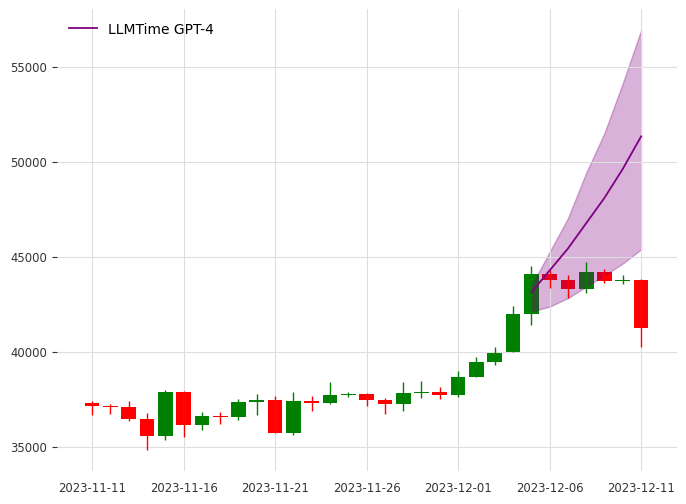

Data set : BTC_Daily_ohlc
from 2023-10-18 to 2023-01-01
training on 48 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

pred dict {'samples': date  2023-12-05 09:00:00  2023-12-06 09:00:00  2023-12-07 09:00:00  \
0            42503.842216         43059.675052         43789.205650   
1            42712.279529         42573.321320         43302.851918   
2            41948.009379         42086.967588         42295.404902   
3            42225.925798         42712.279529         43233.372814   
4            42156.446693         42295.404902         43580.768337   
5            42399.623559         43268.112366         44136.601173   
6            42225.925798         42330.144454         43198.633261   
7            42747.019082         43580.768337         44483.996696   
8            42225.925798         42990.195948         42677.539977   
9            42434.363111         42260.665350         42990.195948   

date  2023-12-08 09:00:00  2023-12-09 09:00:00  2023-12-10 09:00:00  \
0            44518.736248         45873.578787         46846.286251   
1            43407.070575         43511.289232        

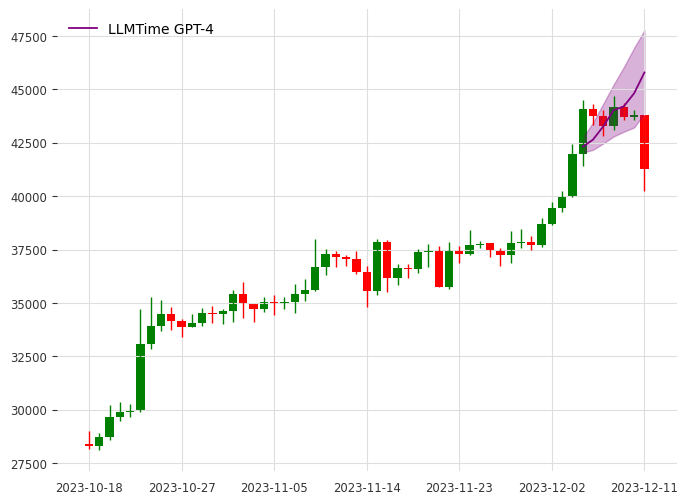

Data set : BTC_Daily_ohlc
from 2023-08-31 to 2023-01-01
training on 96 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


pred dict {'samples': date  2023-12-05 09:00:00  2023-12-06 09:00:00  2023-12-07 09:00:00  \
0            42116.918812         42788.640005         42734.902310   
1            42063.181116         42708.033462         42546.820375   
2            41928.836878         41552.673010         42251.263050   
3            42439.344985         42600.558071         43003.590787   
4            42009.443421         43057.328482         43218.541569   
5            42278.131898         42708.033462         43030.459635   
6            42815.508853         43137.935025         43326.016960   
7            43675.311980         44561.983955         45529.262473   
8            42546.820375         42358.738441         42143.787660   
9            42412.476137         42922.984244         42546.820375   

date  2023-12-08 09:00:00  2023-12-09 09:00:00  2023-12-10 09:00:00  \
0            43030.459635         43057.328482         43621.574285   
1            42949.853091         42654.295766        

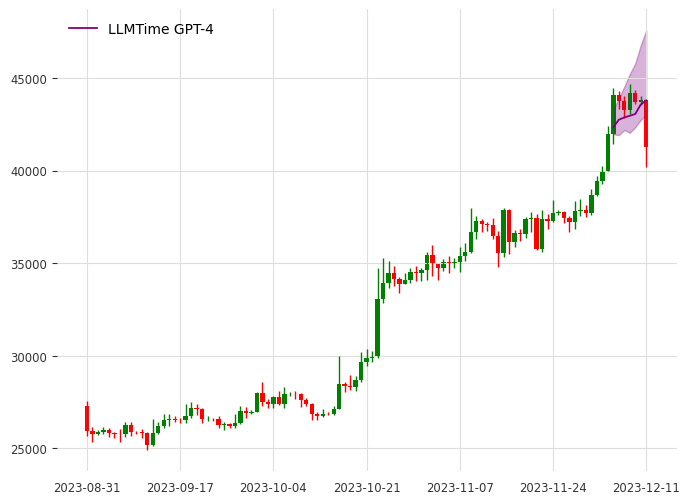

Data set : BTC_Daily_ohlc
from 2023-05-27 to 2023-01-01
training on 192 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


pred dict {'samples': date  2023-12-05 09:00:00  2023-12-06 09:00:00  2023-12-07 09:00:00  \
0            42115.288072         42249.712866         42195.942948   
1            41953.978319         42007.748236         42061.518154   
2            42652.987249         43136.916509         43351.996180   
3            42276.597825         42464.792537         42195.942948   
4            42437.907578         42599.217331         42760.527085   
5            41980.863277         42007.748236         41900.208401   
6            42222.827907         42626.102290         42894.951879   
7            42169.057989         43002.491714         43163.801468   
8            42195.942948         42276.597825         42599.217331   
9            42169.057989         42545.447414         43136.916509   

date  2023-12-08 09:00:00  2023-12-09 09:00:00  2023-12-10 09:00:00  \
0            42303.482784         42222.827907         42276.597825   
1            42034.633195         42411.022619        

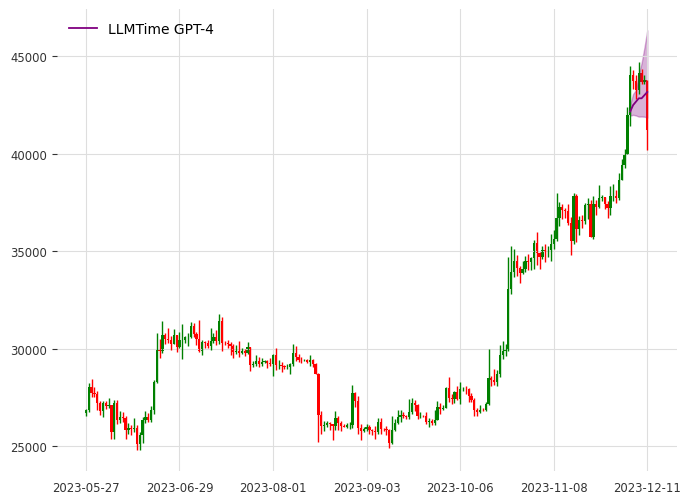

Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only
The path for the pickle file are the following : 
pickle/dic_error_classic_2023-12-12_median.pkl
Data set : BTC_Daily_ohlc
from 2023-12-05 to 2023-01-01
training on 6 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]

pred dict {'samples': date  2023-12-11 09:00:00  2023-12-12 09:00:00  2023-12-13 09:00:00  \
0            44241.121155         43628.787298         43891.216094   
1            44109.906757         43672.525431         44066.168625   
2            43366.358503         43891.216094         43453.834768   
3            44241.121155         43628.787298         44328.597420   
4            43366.358503         43366.358503         43891.216094   
5            44241.121155         43628.787298         43891.216094   
6            44109.906757         43672.525431         44022.430492   
7            44241.121155         43541.311033         43628.787298   
8            43891.216094         43628.787298         43978.692359   
9            44241.121155         43628.787298         44328.597420   

date  2023-12-14 09:00:00  2023-12-15 09:00:00  2023-12-16 09:00:00  \
0            43891.216094         43891.216094         43891.216094   
1            43628.787298         44022.430492        

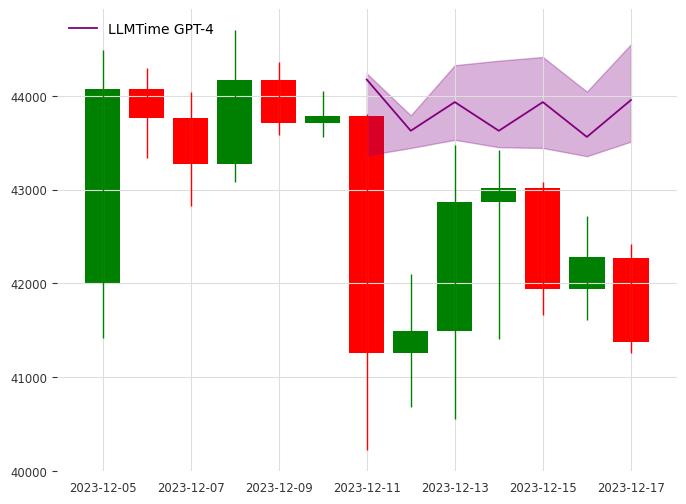

Data set : BTC_Daily_ohlc
from 2023-11-29 to 2023-01-01
training on 12 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

pred dict {'samples': date  2023-12-11 09:00:00  2023-12-12 09:00:00  2023-12-13 09:00:00  \
0            44618.088314         43984.364911         43905.149486   
1            43825.934060         43667.503210         43905.149486   
2            43509.072359         43905.149486         43548.680072   
3            43825.934060         44063.580336         44261.618900   
4            43588.287784         43667.503210         43627.895497   
5            44538.872888         45331.027141         45845.927406   
6            43588.287784         43667.503210         43865.541773   
7            43627.895497         43667.503210         43588.287784   
8            43627.895497         43865.541773         43944.757198   
9            43509.072359         44261.618900         43984.364911   

date  2023-12-14 09:00:00  2023-12-15 09:00:00  2023-12-16 09:00:00  \
0            44697.303739         44182.403474         44063.580336   
1            43865.541773         43944.757198        

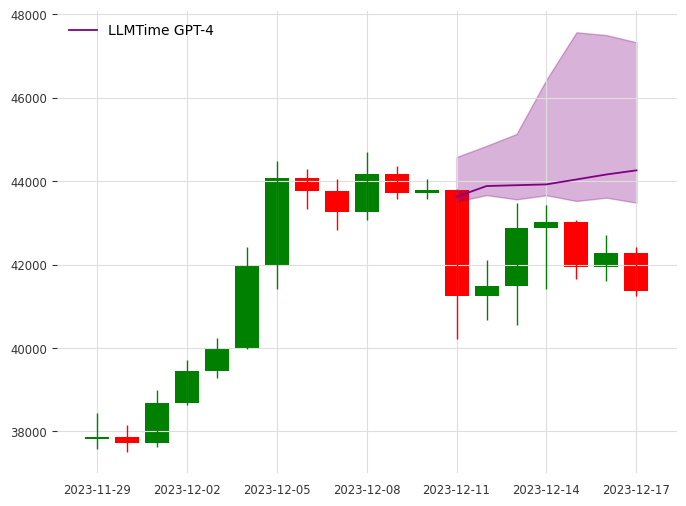

Data set : BTC_Daily_ohlc
from 2023-11-17 to 2023-01-01
training on 24 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]

pred dict {'samples': date  2023-12-11 09:00:00  2023-12-12 09:00:00  2023-12-13 09:00:00  \
0            43940.624188         44352.509033         44202.732726   
1            44315.064956         44389.953110         44577.173494   
2            44090.400495         44165.288649         44052.956419   
3            43940.624188         44389.953110         44989.058340   
4            44277.620880         44315.064956         44801.837956   
5            43828.291957         44127.844572         44427.397187   
6            43865.736034         44839.282032         45213.722801   
7            43978.068265         44427.397187         44614.617571   
8            44427.397187         43978.068265         44240.176803   
9            44277.620880         44052.956419         44127.844572   

date  2023-12-14 09:00:00  2023-12-15 09:00:00  2023-12-16 09:00:00  \
0            44277.620880         44689.505725         44989.058340   
1            44502.285341         44577.173494        

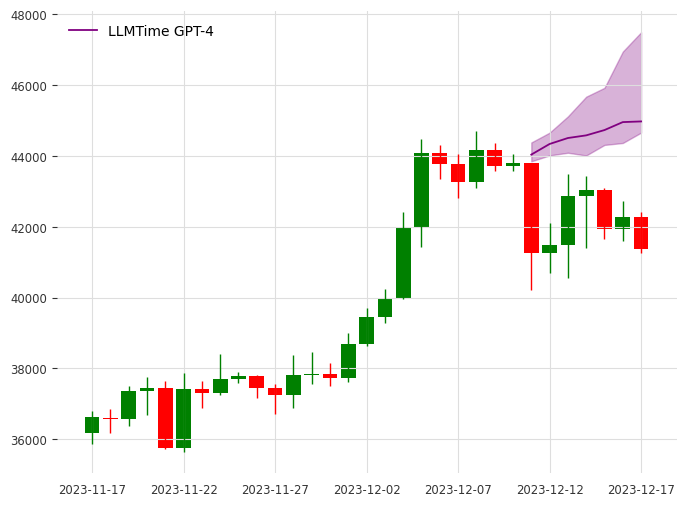

Data set : BTC_Daily_ohlc
from 2023-10-24 to 2023-01-01
training on 48 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.17s/it]

pred dict {'samples': date  2023-12-11 09:00:00  2023-12-12 09:00:00  2023-12-13 09:00:00  \
0            44098.961539         44524.182542         44807.663211   
1            44028.091372         43992.656288         43921.786121   
2            44240.701873         44382.442208         44701.357960   
3            44098.961539         44382.442208         44488.747459   
4            44240.701873         43921.786121         44524.182542   
5            44205.266790         44417.877291         44488.747459   
6            44240.701873         44559.617626         44807.663211   
7            44630.487793         44134.396623         44205.266790   
8            44311.572041         44913.968462         45126.578963   
9            43709.175619         43886.351037         44028.091372   

date  2023-12-14 09:00:00  2023-12-15 09:00:00  2023-12-16 09:00:00  \
0            44949.403545         45055.708796         45551.799967   
1            44098.961539         44524.182542        

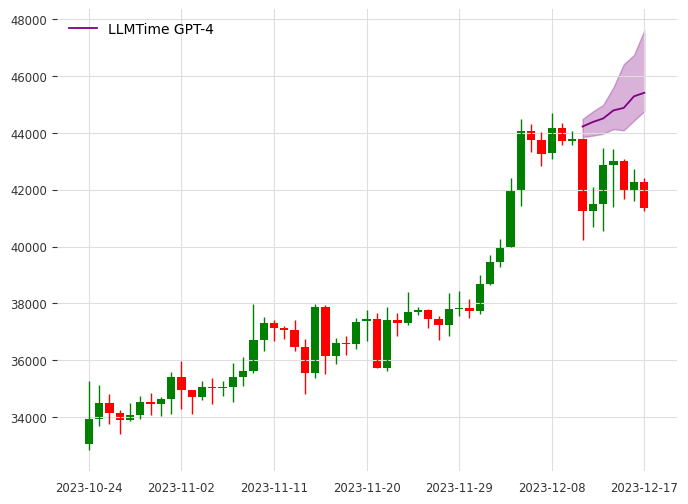

Data set : BTC_Daily_ohlc
from 2023-09-06 to 2023-01-01
training on 96 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]

pred dict {'samples': date  2023-12-11 09:00:00  2023-12-12 09:00:00  2023-12-13 09:00:00  \
0            43805.029096         44104.039534         44049.673999   
1            44294.318903         44321.501670         44457.415505   
2            44022.491232         45028.253613         45898.102159   
3            43886.577397         43995.308465         44104.039534   
4            44185.587835         44022.491232         43641.932494   
5            43805.029096         45191.350215         44946.705312   
6            43832.211863         43805.029096         43478.835891   
7            43805.029096         43886.577397         44267.136136   
8            43832.211863         43478.835891         43777.846329   
9            44185.587835         44321.501670         44158.405068   

date  2023-12-14 09:00:00  2023-12-15 09:00:00  2023-12-16 09:00:00  \
0            44457.415505         46903.864539         46632.036869   
1            44946.705312         45517.543420        

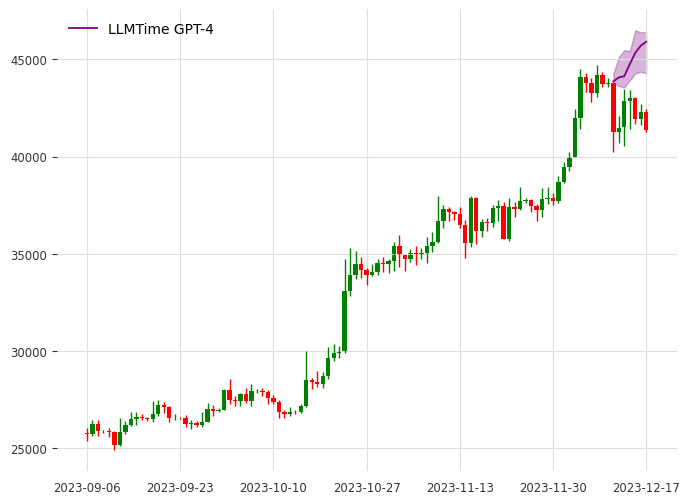

Data set : BTC_Daily_ohlc
from 2023-06-02 to 2023-01-01
training on 192 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

pred dict {'samples': date  2023-12-11 09:00:00  2023-12-12 09:00:00  2023-12-13 09:00:00  \
0            44207.362457         44234.342843         44396.225159   
1            43856.617439         43829.637053         43829.637053   
2            43991.519369         44423.205545         44639.048632   
3            43775.676281         44234.342843         43991.519369   
4            43586.813579         44099.440913         43775.676281   
5            43721.715509         43856.617439         43937.558597   
6            43748.695895         44072.460527         43424.931263   
7            43748.695895         43424.931263         43317.009719   
8            43640.774351         44153.401685         44207.362457   
9            43856.617439         44719.989790         44342.264387   

date  2023-12-14 09:00:00  2023-12-15 09:00:00  2023-12-16 09:00:00  \
0            44612.068246         45124.695580         45610.342528   
1            43910.578211         43883.597825        

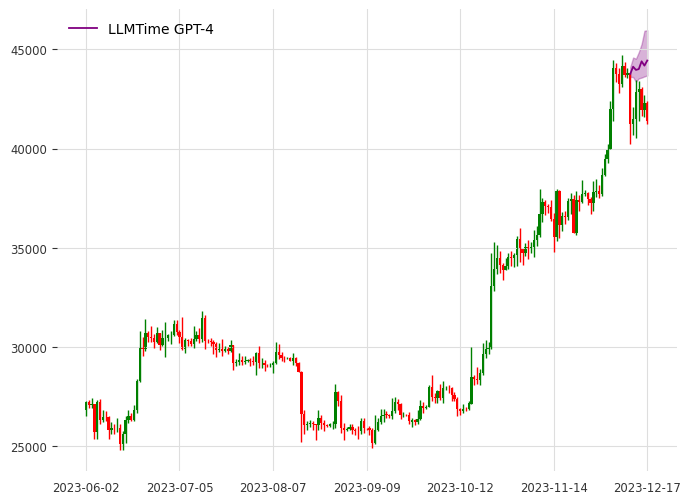

Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only
The path for the pickle file are the following : 
pickle/dic_error_classic_2023-12-18_median.pkl
Data set : BTC_Daily_ohlc
from 2023-12-11 to 2023-01-01
training on 6 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

pred dict {'samples': date  2023-12-17 09:00:00  2023-12-18 09:00:00  2023-12-19 09:00:00  \
0            42695.649354         42945.941387         44364.262909   
1            42945.941387         43196.233420         44572.839604   
2            42612.218676         43696.817487         43863.678843   
3            42779.080032         42945.941387         42320.211304   
4            44030.540198         44197.401554         43613.386809   
5            43696.817487         44030.540198         42945.941387   
6            42945.941387         43196.233420         44572.839604   
7            42945.941387         43279.664098         43279.664098   
8            41527.619865         41777.911898         43154.518082   
9            43112.802743         43446.525454         42361.926643   

date  2023-12-20 09:00:00  2023-12-21 09:00:00  2023-12-22 09:00:00  \
0            44531.124265         43446.525454         43780.248165   
1            44739.700959         43655.102148        

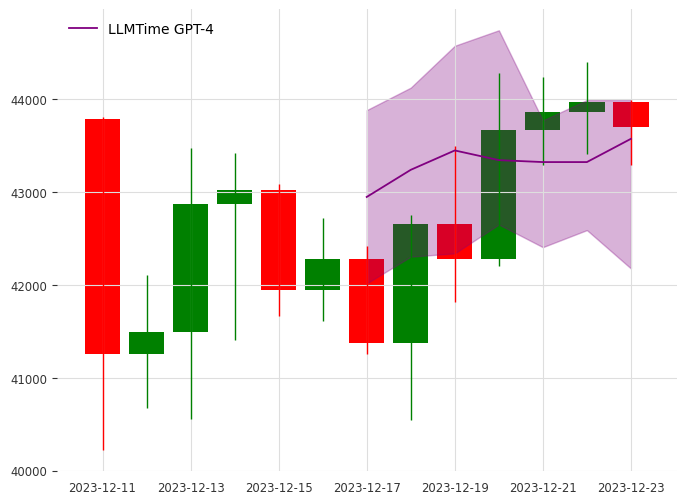

Data set : BTC_Daily_ohlc
from 2023-12-05 to 2023-01-01
training on 12 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]

pred dict {'samples': date  2023-12-17 09:00:00  2023-12-18 09:00:00  2023-12-19 09:00:00  \
0            42348.868217         43622.518389         43792.338412   
1            42518.688240         42773.418275         41839.408149   
2            42518.688240         42603.598252         41160.128057   
3            42518.688240         42688.508263         42009.228172   
4            43113.058321         42348.868217         43282.878344   
5            42603.598252         42773.418275         41669.588126   
6            42688.508263         42943.238298         42009.228172   
7            40226.117931         40480.847965         41839.408149   
8            42773.418275         43070.603315         42518.688240   
9            42773.418275         42943.238298         41839.408149   

date  2023-12-20 09:00:00  2023-12-21 09:00:00  2023-12-22 09:00:00  \
0            43113.058321         43452.698366         42900.783292   
1            42179.048195         42348.868217        

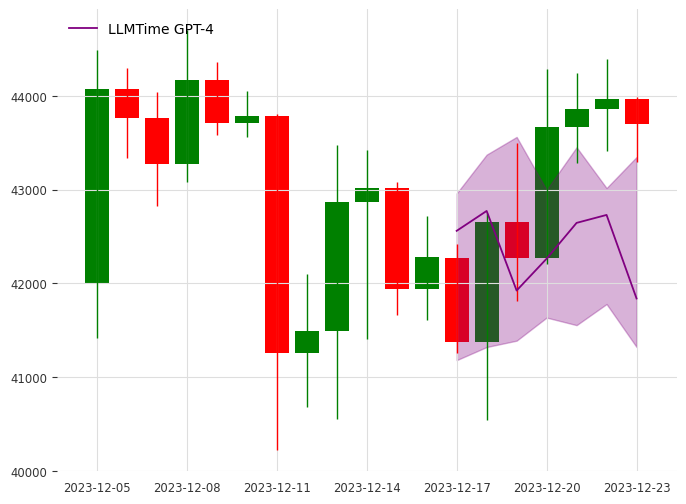

Data set : BTC_Daily_ohlc
from 2023-11-23 to 2023-01-01
training on 24 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

pred dict {'samples': date  2023-12-17 09:00:00  2023-12-18 09:00:00  2023-12-19 09:00:00  \
0            42261.262327         42336.965439         42412.668551   
1            42450.520107         42526.223219         42223.410771   
2            42639.777888         43056.145004         43245.402784   
3            42261.262327         42564.074775         42185.559215   
4            42299.113883         42336.965439         42223.410771   
5            42601.926332         42753.332556         42488.371663   
6            42564.074775         43283.254340         43775.324569   
7            42336.965439         41617.785874         41390.676538   
8            42488.371663         42715.481000         42942.590336   
9            42942.590336         43321.105896         43396.809009   

date  2023-12-20 09:00:00  2023-12-21 09:00:00  2023-12-22 09:00:00  \
0            42488.371663         42564.074775         42639.777888   
1            42488.371663         42336.965439        

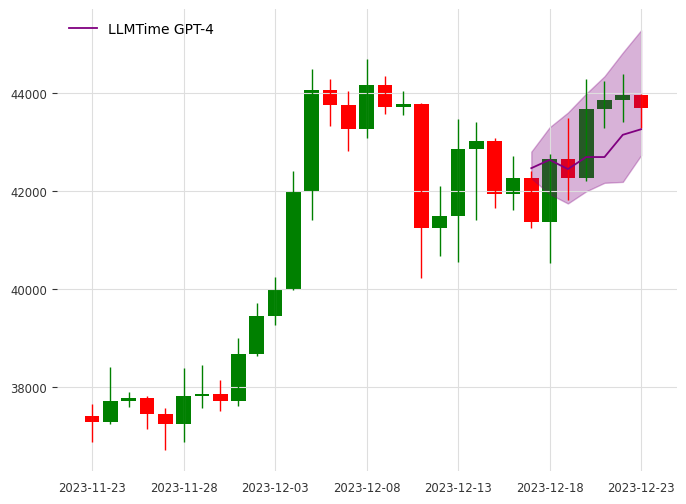

Data set : BTC_Daily_ohlc
from 2023-10-30 to 2023-01-01
training on 48 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

pred dict {'samples': date  2023-12-17 09:00:00  2023-12-18 09:00:00  2023-12-19 09:00:00  \
0            42516.581044         42626.301253         42918.888478   
1            41675.392774         42004.553401         42480.007641   
2            42443.434238         42370.287432         42516.581044   
3            42370.287432         42516.581044         42992.035284   
4            42992.035284         42955.461881         42553.154447   
5            42516.581044         42845.741672         43248.049105   
6            42150.847014         42918.888478         43138.328896   
7            42553.154447         42992.035284         43248.049105   
8            42114.273611         42333.714029         42992.035284   
9            42370.287432         42992.035284         42772.594865   

date  2023-12-20 09:00:00  2023-12-21 09:00:00  2023-12-22 09:00:00  \
0            43174.902299         43321.195911         43577.209733   
1            42699.448059         42553.154447        

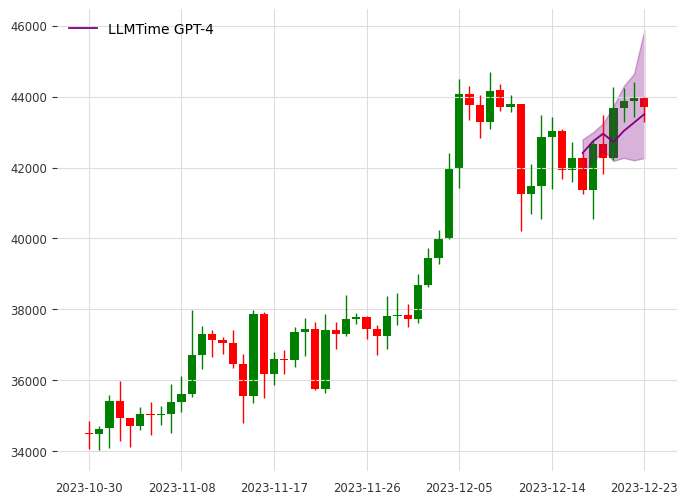

Data set : BTC_Daily_ohlc
from 2023-09-12 to 2023-01-01
training on 96 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

pred dict {'samples': date  2023-12-17 09:00:00  2023-12-18 09:00:00  2023-12-19 09:00:00  \
0            42814.310798         42897.364748         43008.103347   
1            42454.410352         42758.941499         43755.588889   
2            42482.095002         42509.779651         42315.987103   
3            42232.933154         42371.356403         42260.617804   
4            42315.987103         42122.194555         43091.157296   
5            42232.933154         42952.734047         43644.850290   
6            42260.617804         43035.787996         43368.003793   
7            42620.518250         42703.572200         44198.543285   
8            41845.348058         42122.194555         41568.501561   
9            42260.617804         42094.509906         42841.995448   

date  2023-12-20 09:00:00  2023-12-21 09:00:00  2023-12-22 09:00:00  \
0            43700.219590         43894.012138         44060.120036   
1            44336.966533         44503.074432        

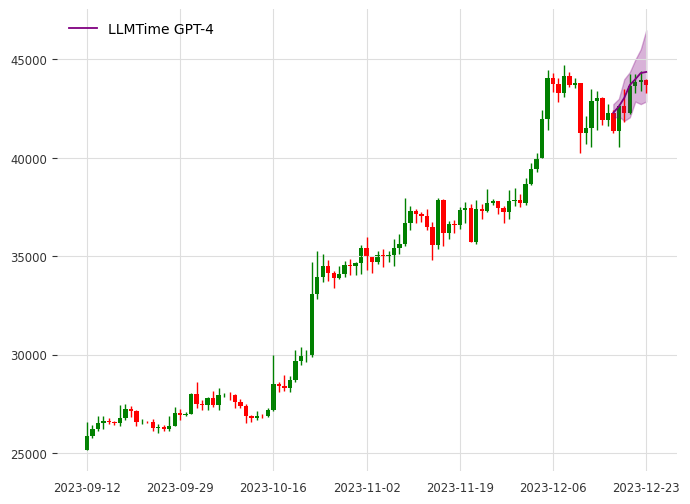

Data set : BTC_Daily_ohlc
from 2023-06-08 to 2023-01-01
training on 192 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.75s/it]


pred dict {'samples': date  2023-12-17 09:00:00  2023-12-18 09:00:00  2023-12-19 09:00:00  \
0            42315.717902         42451.388687         42587.059472   
1            42451.388687         42342.852059         42397.120373   
2            42288.583745         37512.972106         39602.302198   
3            42342.852059         42532.791158         42397.120373   
4            42641.327786         42939.803513         41908.705546   
5            42207.181273         42152.912959         42532.791158   
6            43563.889125         43753.828225         44187.974737   
7            42044.376331         42180.047116         42044.376331   
8            42559.925315         42342.852059         42831.266885   
9            42342.852059         42885.535199         42966.937671   

date  2023-12-20 09:00:00  2023-12-21 09:00:00  2023-12-22 09:00:00  \
0            42342.852059         42478.522844         42722.730257   
1            42369.986216         42505.657001        

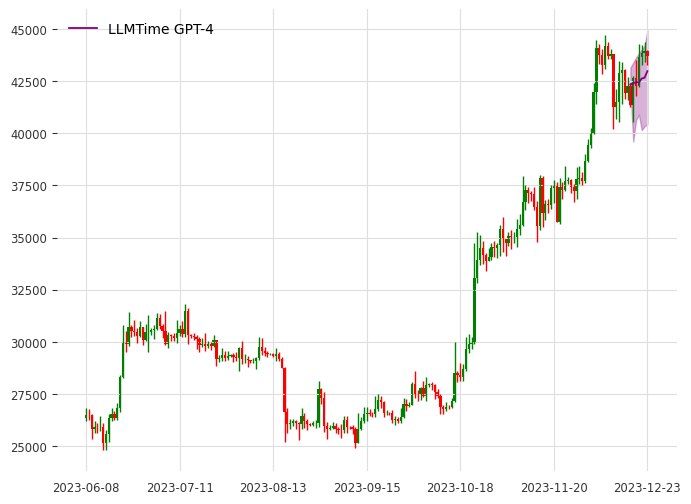

Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only
The path for the pickle file are the following : 
pickle/dic_error_classic_2023-12-24_median.pkl
Data set : BTC_Daily_ohlc
from 2023-12-17 to 2023-01-01
training on 6 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

pred dict {'samples': date  2023-12-23 09:00:00  2023-12-24 09:00:00  2023-12-25 09:00:00  \
0            44228.584708         44483.382124         44695.713303   
1            44058.719765         44313.517180         44525.848360   
2            45417.639314         45672.436729         45969.700381   
3            44058.719765         44695.713303         44186.118472   
4            45375.173078         45757.369201         46012.166617   
5            44143.652236         44313.517180         44440.915888   
6            44313.517180         44653.247067         44908.044483   
7            45290.240606         45757.369201         45460.105550   
8            44143.652236         44398.449652         44653.247067   
9            45247.774370         45375.173078         45545.038022   

date  2023-12-26 09:00:00  2023-12-27 09:00:00  2023-12-28 09:00:00  \
0            44695.713303         44695.713303         44695.713303   
1            44823.112011         45077.909427        

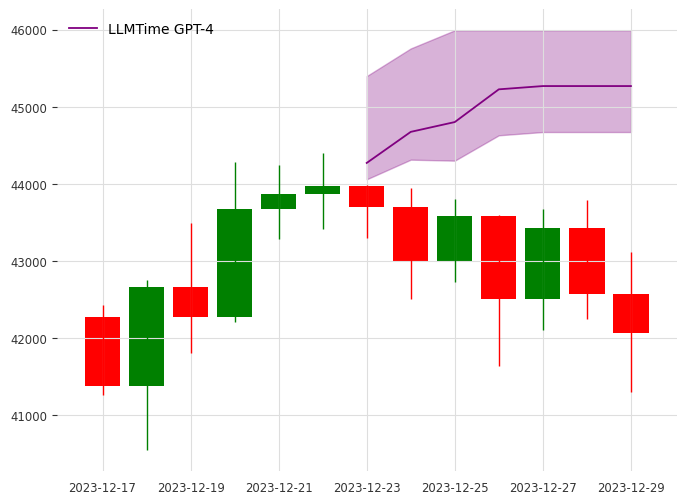

Data set : BTC_Daily_ohlc
from 2023-12-11 to 2023-01-01
training on 12 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

pred dict {'samples': date  2023-12-23 09:00:00  2023-12-24 09:00:00  2023-12-25 09:00:00  \
0            45508.504234         45718.705177         44625.660272   
1            42775.891970         44205.258385         42733.851782   
2            42733.851782         43070.173291         42187.329329   
3            42859.972348         43196.293857         42313.449895   
4            42944.052725         43280.374234         42397.530272   
5            42859.972348         43196.293857         42313.449895   
6            42859.972348         43196.293857         42313.449895   
7            42902.012536         43322.414423         42397.530272   
8            42859.972348         43196.293857         42313.449895   
9            43280.374234         43616.695744         42733.851782   

date  2023-12-26 09:00:00  2023-12-27 09:00:00  2023-12-28 09:00:00  \
0            44961.981781         44079.137819         45340.343479   
1            41808.967631         43364.454612        

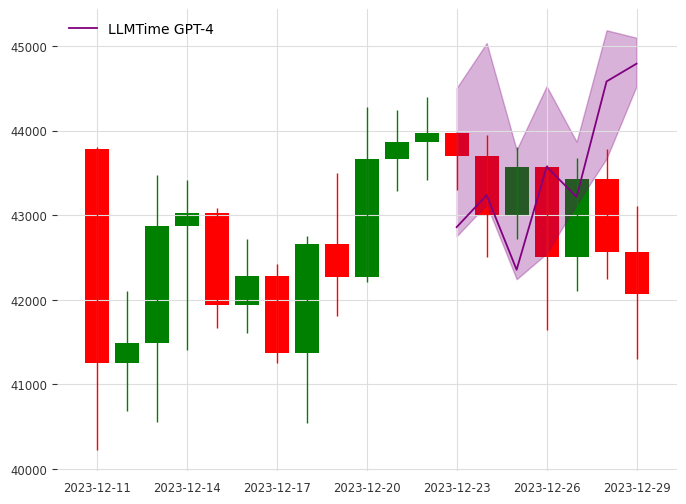

Data set : BTC_Daily_ohlc
from 2023-11-29 to 2023-01-01
training on 24 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.00s/it]

pred dict {'samples': date  2023-12-23 09:00:00  2023-12-24 09:00:00  2023-12-25 09:00:00  \
0            44154.783240         44445.138789         43822.948326   
1            43947.386418         44071.824511         43905.907054   
2            44154.783240         44486.618154         44279.221332   
3            43781.468961         44154.783240         44320.700697   
4            44362.180061         44486.618154         44611.056246   
5            43947.386418         44486.618154         44942.891160   
6            44196.262604         44403.659425         44611.056246   
7            44113.303875         44279.221332         44445.138789   
8            44154.783240         43532.592776         43615.551504   
9            43947.386418         43698.510233         44154.783240   

date  2023-12-26 09:00:00  2023-12-27 09:00:00  2023-12-28 09:00:00  \
0            44113.303875         43449.634047         43864.427690   
1            44196.262604         43739.989597        

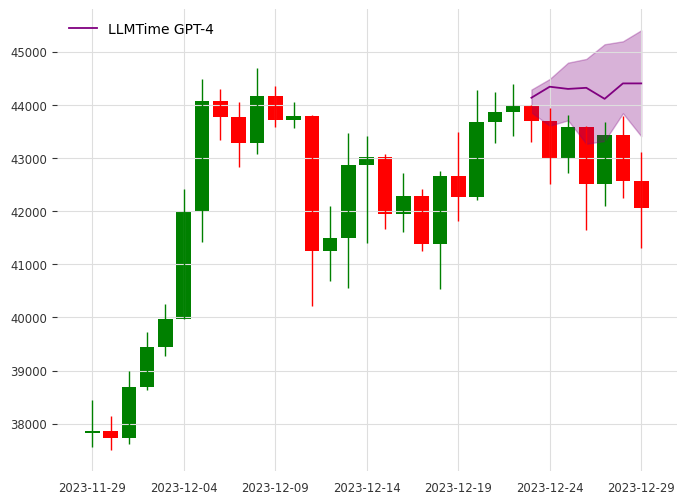

Data set : BTC_Daily_ohlc
from 2023-11-05 to 2023-01-01
training on 48 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

pred dict {'samples': date  2023-12-23 09:00:00  2023-12-24 09:00:00  2023-12-25 09:00:00  \
0            44064.428157         43766.065546         43803.360872   
1            44101.723483         44362.790768         44437.381421   
2            44139.018810         44437.381421         44549.267400   
3            45034.106644         45668.127193         46190.261763   
4            44250.904789         44474.676748         44586.562727   
5            42833.682385         43057.454344         42498.024448   
6            44213.609463         44474.676748         44884.925338   
7            44884.925338         45929.194478         46600.510353   
8            44922.220665         46003.785131         45780.013172   
9            44064.428157         44027.132831         44362.790768   

date  2023-12-26 09:00:00  2023-12-27 09:00:00  2023-12-28 09:00:00  \
0            44027.132831         44101.723483         44176.314136   
1            44623.858053         44847.630012        

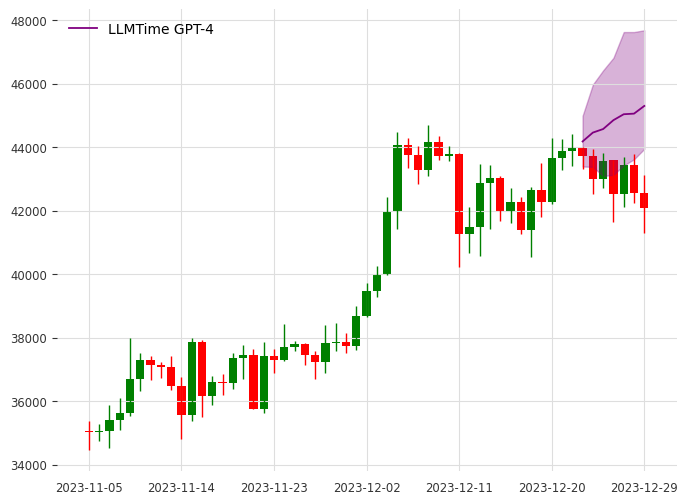

Data set : BTC_Daily_ohlc
from 2023-09-18 to 2023-01-01
training on 96 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


pred dict {'samples': date  2023-12-23 09:00:00  2023-12-24 09:00:00  2023-12-25 09:00:00  \
0            43998.062447         44139.854463         43884.628835   
1            44083.137657         43941.345641         43487.611191   
2            44253.288076         44083.137657         44338.363285   
3            43771.195222         43827.912029         43742.836819   
4            44111.496060         44026.420851         44253.288076   
5            43289.102369         42721.934307         42892.084726   
6            44083.137657         44196.571269         44111.496060   
7            45104.040169         45330.907394         46068.225876   
8            43912.987238         44139.854463         44054.779254   
9            44054.779254         44253.288076         44366.721688   

date  2023-12-26 09:00:00  2023-12-27 09:00:00  2023-12-28 09:00:00  \
0            44196.571269         44366.721688         44508.513704   
1            43147.310354         43601.044804        

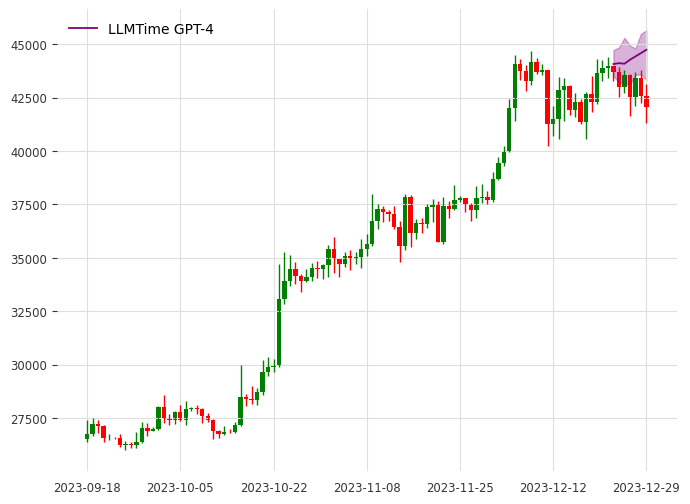

Data set : BTC_Daily_ohlc
from 2023-06-14 to 2023-01-01
training on 192 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


pred dict {'samples': date  2023-12-23 09:00:00  2023-12-24 09:00:00  2023-12-25 09:00:00  \
0            44615.577726         44752.814200         45246.865507   
1            43764.711587         43984.289945         43901.948061   
2            43051.081921         44121.526419         44231.315598   
3            44039.184535         45246.865507         46372.204594   
4            44039.184535         44094.079124         44148.973714   
5            44148.973714         44203.868304         44176.421009   
6            44039.184535         44121.526419         44203.868304   
7            43984.289945         43847.053471         43572.580523   
8            44121.526419         44176.421009         44203.868304   
9            44066.631830         44341.104778         44752.814200   

date  2023-12-26 09:00:00  2023-12-27 09:00:00  2023-12-28 09:00:00  \
0            45576.233045         46262.415415         46756.466722   
1            44039.184535         43956.842650        

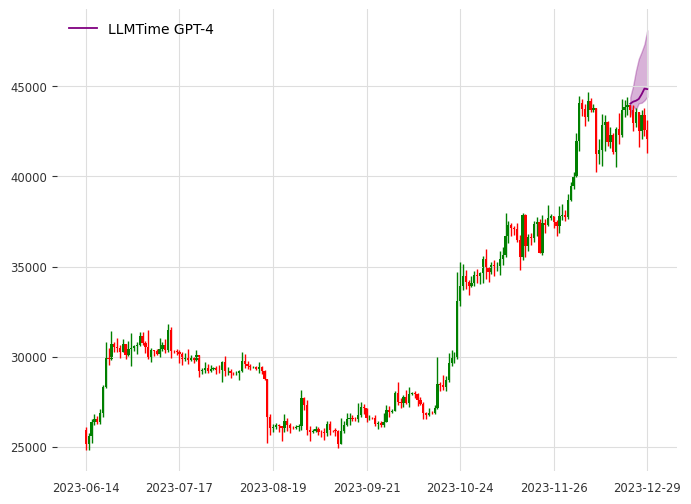

Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only
The path for the pickle file are the following : 
pickle/dic_error_classic_2023-12-30_median.pkl
Data set : BTC_Daily_ohlc
from 2023-12-23 to 2023-01-01
training on 6 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

pred dict {'samples': date  2023-12-29 09:00:00  2023-12-30 09:00:00  2023-12-31 09:00:00  \
0            43313.478998         42586.240338         42586.240338   
1            43313.478998         42586.240338         43185.142764   
2            43313.478998         42586.240338         43185.142764   
3            43313.478998         42586.240338         43185.142764   
4            43313.478998         42586.240338         43185.142764   
5            43313.478998         42586.240338         43185.142764   
6            43313.478998         42329.567870         43185.142764   
7            43313.478998         42586.240338         43185.142764   
8            43313.478998         42586.240338         43185.142764   
9            43313.478998         42586.240338         43185.142764   

date  2024-01-01 09:00:00  2024-01-02 09:00:00  2024-01-03 09:00:00  \
0            42586.240338         42586.240338         42586.240338   
1            42629.019083         43056.806530        

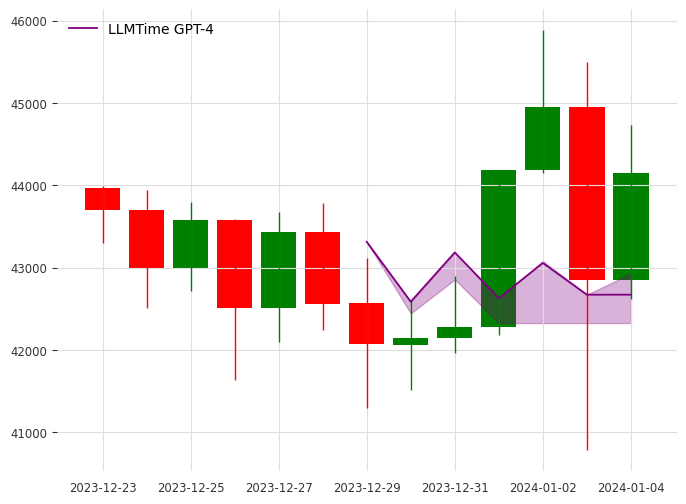

Data set : BTC_Daily_ohlc
from 2023-12-17 to 2023-01-01
training on 12 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


pred dict {'samples': date  2023-12-29 09:00:00  2023-12-30 09:00:00  2023-12-31 09:00:00  \
0            43252.562384         42613.676677         43082.192862   
1            43465.524286         42784.046199         43337.747145   
2            42997.008101         42485.899535         42911.823340   
3            43550.709047         42954.415721         43763.670950   
4            42400.714774         43550.709047         42485.899535   
5            42315.530013         42656.269057         41719.236686   
6            43465.524286         42187.752872         43295.154764   
7            43763.670950         42656.269057         43508.116667   
8            43295.154764         42741.453818         43209.970003   
9            43508.116667         42784.046199         43380.339525   

date  2024-01-01 09:00:00  2024-01-02 09:00:00  2024-01-03 09:00:00  \
0            42656.269057         42911.823340         42698.861438   
1            42698.861438         43295.154764        

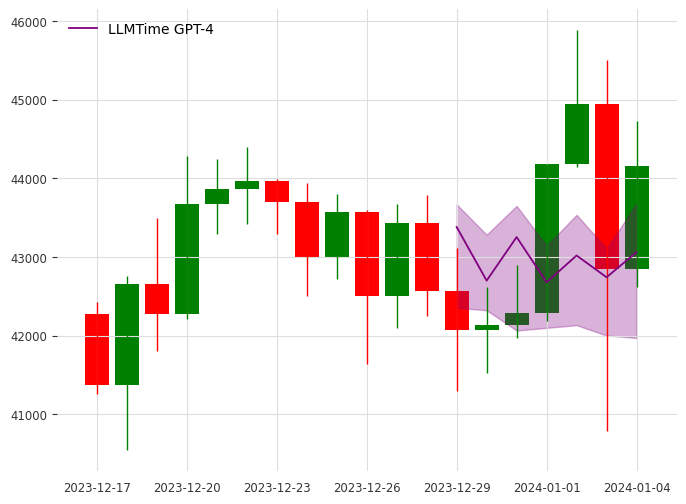

Data set : BTC_Daily_ohlc
from 2023-12-05 to 2023-01-01
training on 24 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

pred dict {'samples': date  2023-12-29 09:00:00  2023-12-30 09:00:00  2023-12-31 09:00:00  \
0            42793.025412         42452.553803         42920.702266   
1            43303.732826         43516.527582         42793.025412   
2            42835.584363         44069.793947         43090.938070   
3            43218.614924         42920.702266         43644.204436   
4            43559.086533         43942.117094         43686.763387   
5            43218.614924         42239.759047         43516.527582   
6            43218.614924         42367.435900         42495.112754   
7            43346.291777         43090.938070         43729.322338   
8            43346.291777         44069.793947         43771.881289   
9            43005.820168         41516.256877         42282.317998   

date  2024-01-01 09:00:00  2024-01-02 09:00:00  2024-01-03 09:00:00  \
0            42239.759047         42367.435900         41729.051633   
1            43346.291777         42282.317998        

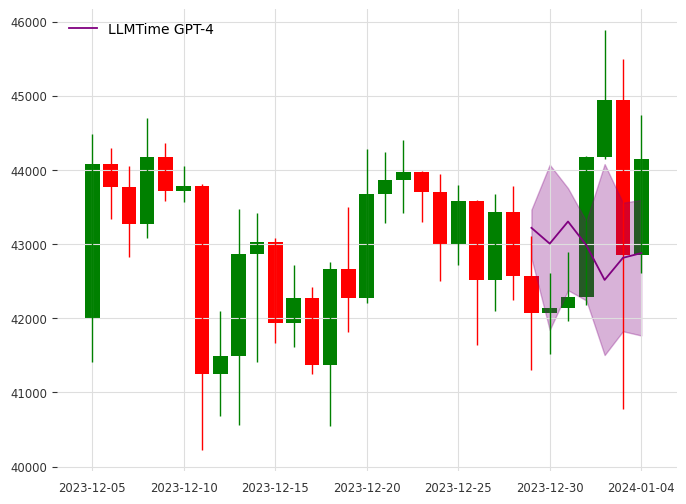

Data set : BTC_Daily_ohlc
from 2023-11-11 to 2023-01-01
training on 48 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]

pred dict {'samples': date  2023-12-29 09:00:00  2023-12-30 09:00:00  2023-12-31 09:00:00  \
0            43505.079405         42637.617917         43957.668008   
1            42901.627935         43090.206520         43731.373706   
2            42863.912219         43090.206520         42147.313598   
3            42675.333634         42260.460749         43580.510839   
4            42901.627935         42260.460749         42977.059369   
5            43354.216538         43316.500821         44033.099441   
6            42637.617917         43203.353670         42939.343652   
7            43014.775086         42675.333634         42939.343652   
8            43391.932255         42599.902200         43241.069387   
9            42977.059369         43165.637953         42373.607899   

date  2024-01-01 09:00:00  2024-01-02 09:00:00  2024-01-03 09:00:00  \
0            44221.678026         44259.393743         43995.383724   
1            42713.049351         43278.785104        

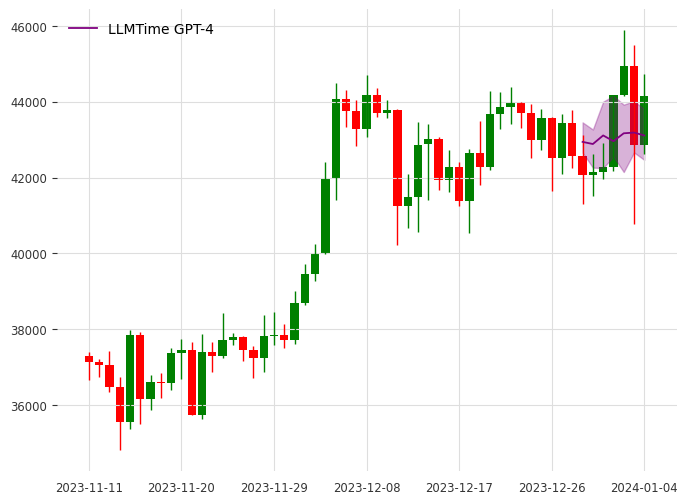

Data set : BTC_Daily_ohlc
from 2023-09-24 to 2023-01-01
training on 96 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]

pred dict {'samples': date  2023-12-29 09:00:00  2023-12-30 09:00:00  2023-12-31 09:00:00  \
0            43182.408664         43087.814122         42867.093523   
1            43119.345636         43466.192292         43844.570462   
2            42772.498980         42709.435952         43497.723806   
3            42646.372923         42898.625037         42961.688065   
4            43087.814122         43466.192292         43403.129264   
5            43371.597749         43403.129264         43466.192292   
6            43119.345636         42677.904437         43592.318349   
7            43277.003207         42520.246867         42267.994753   
8            42583.309895         42331.057782         43087.814122   
9            43245.471693         43340.066235         43781.507434   

date  2024-01-01 09:00:00  2024-01-02 09:00:00  2024-01-03 09:00:00  \
0            43655.381377         44380.606203         45610.335256   
1            44128.354090         44885.110430        

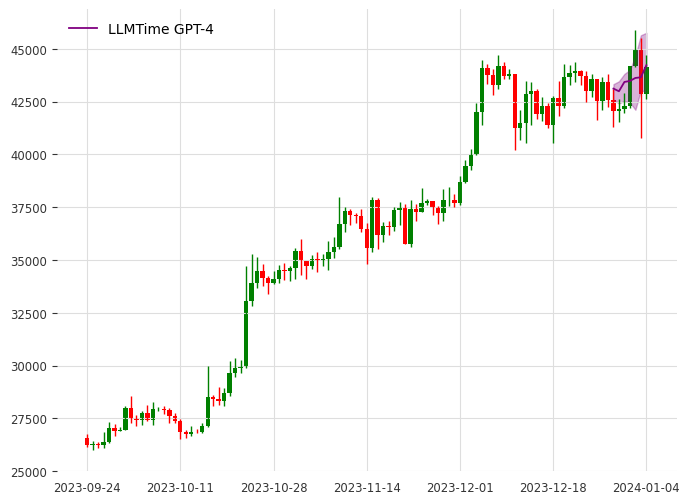

Data set : BTC_Daily_ohlc
from 2023-06-20 to 2023-01-01
training on 192 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


pred dict {'samples': date  2023-12-29 09:00:00  2023-12-30 09:00:00  2023-12-31 09:00:00  \
0            42481.839160         42370.081609         42258.324058   
1            42733.293650         42705.354263         42817.111814   
2            42509.778548         42537.717936         42621.536099   
3            42817.111814         43375.899570         43599.414672   
4            43320.020794         43264.142019         43375.899570   
5            42621.536099         43208.263243         42984.748141   
6            43096.505692         42425.960385         43543.535897   
7            42649.475487         43655.293448         44158.202429   
8            42733.293650         43096.505692         43320.020794   
9            42593.596711         42481.839160         42817.111814   

date  2024-01-01 09:00:00  2024-01-02 09:00:00  2024-01-03 09:00:00  \
0            42565.657324         42621.536099         42733.293650   
1            42872.990589         43040.626916        

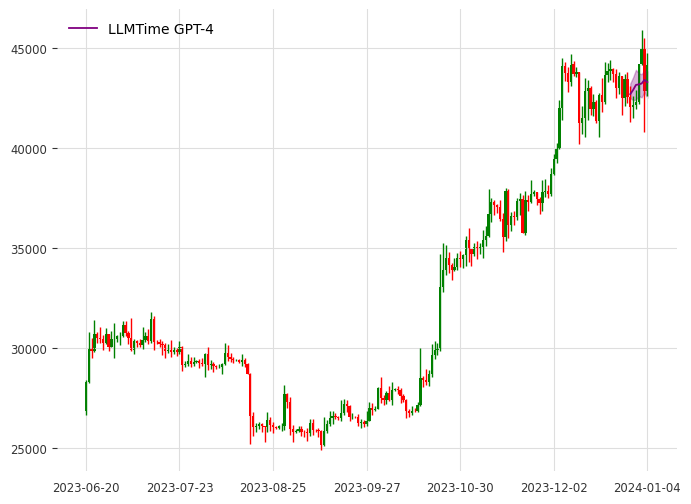

Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only
The path for the pickle file are the following : 
pickle/dic_error_classic_2024-01-05_median.pkl
Data set : BTC_Daily_ohlc
from 2023-12-29 to 2023-01-01
training on 6 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

pred dict {'samples': date  2024-01-04 09:00:00  2024-01-05 09:00:00  2024-01-06 09:00:00  \
0            43667.760688         44427.567061         42359.205269   
1            45145.161968         45229.584898         45356.219294   
2            43541.126293         44765.258782         45862.756875   
3            38475.750476         45145.161968         42950.165781   
4            41514.975966         41219.495710         40670.746663   
5            41937.090617         42148.147943         44047.663874   
6            43667.760688         43203.434572         44849.681712   
7            43498.914828         43414.491897         43287.857502   
8            41937.090617         41219.495710         42781.319920   
9            43752.183618         42063.725013         40881.803989   

date  2024-01-07 09:00:00  2024-01-08 09:00:00  2024-01-09 09:00:00  \
0            44005.452409         44765.258782         44765.258782   
1            47255.735225         48015.541598        

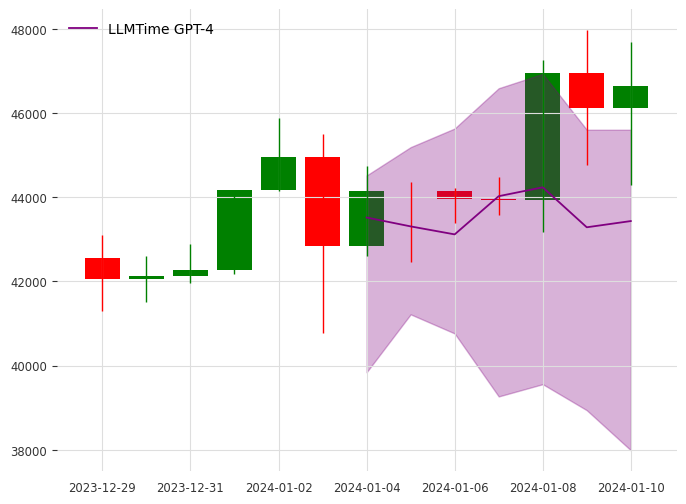

Data set : BTC_Daily_ohlc
from 2023-12-23 to 2023-01-01
training on 12 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.97s/it]

pred dict {'samples': date  2024-01-04 09:00:00  2024-01-05 09:00:00  2024-01-06 09:00:00  \
0            44247.932953         42504.381534         43907.727798   
1            43482.471355         42929.637978         43524.996999   
2            44035.304731         43014.689267         43610.048288   
3            44332.984242         43354.894422         44035.304731   
4            42759.535401         42802.061045         42887.112334   
5            43354.894422         42461.855890         41994.073802   
6            42334.278957         43695.099576         43014.689267   
7            43780.150865         43099.740555         43695.099576   
8            44247.932953         42802.061045         44077.830376   
9            44503.086819         41994.073802         43524.996999   

date  2024-01-07 09:00:00  2024-01-08 09:00:00  2024-01-09 09:00:00  \
0            42164.176380         43014.689267         41781.445580   
1            42461.855890         43397.420066        

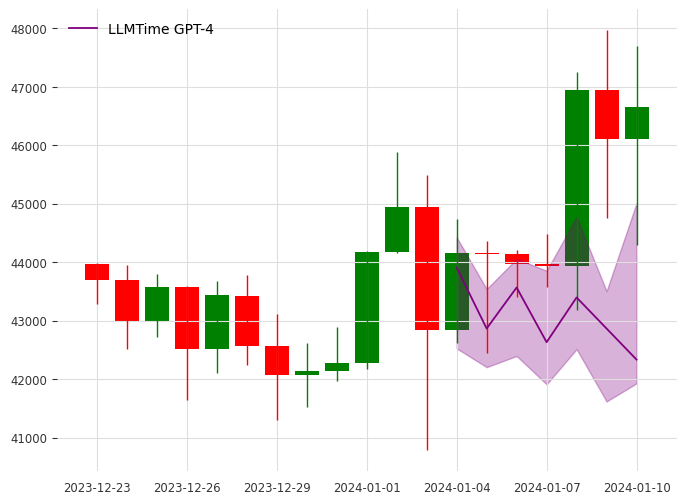

Data set : BTC_Daily_ohlc
from 2023-12-11 to 2023-01-01
training on 24 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

pred dict {'samples': date  2024-01-04 09:00:00  2024-01-05 09:00:00  2024-01-06 09:00:00  \
0            43059.038321         43524.084390         42593.992251   
1            42593.992251         42213.500013         43185.869067   
2            43016.761405         42509.438421         43228.145982   
3            41241.130959         42467.161505         43989.130459   
4            43185.869067         43904.576628         44411.899613   
5            42805.376828         43904.576628         43354.976728   
6            42636.269167         42255.776928         42889.930659   
7            42974.484490         43524.084390         42593.992251   
8            42424.884590         41494.792451         43101.315236   
9            43228.145982         43524.084390         44919.222598   

date  2024-01-07 09:00:00  2024-01-08 09:00:00  2024-01-09 09:00:00  \
0            42636.269167         42720.822997         44285.068867   
1            42805.376828         43777.745882        

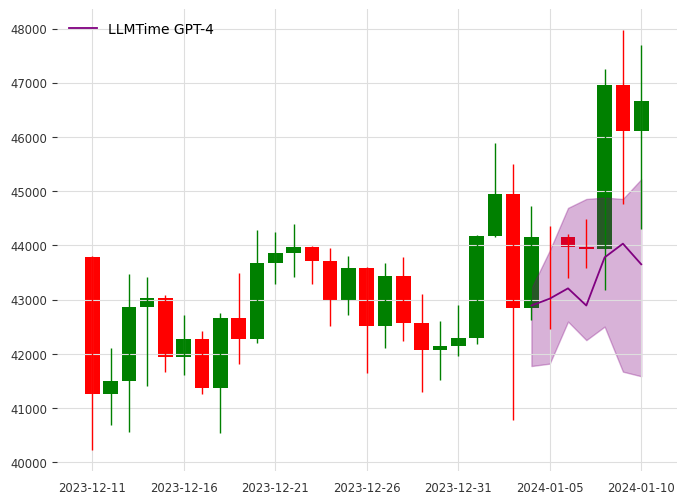

Data set : BTC_Daily_ohlc
from 2023-11-17 to 2023-01-01
training on 48 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


pred dict {'samples': date  2024-01-04 09:00:00  2024-01-05 09:00:00  2024-01-06 09:00:00  \
0            42926.882786         43043.163281         44554.809718   
1            43857.126747         43973.407242         42926.882786   
2            44322.248728         43702.086087         44205.968233   
3            44903.651204         48624.627048         49283.549853   
4            42965.642951         43547.045427         43818.366582   
5            43198.203942         43004.403116         43120.683611   
6            44748.610543         45252.492689         45330.013019   
7            43508.285262         43004.403116         43585.805592   
8            44012.167408         43624.565757         44089.687738   
9            43779.606417         44671.090213         43818.366582   

date  2024-01-07 09:00:00  2024-01-08 09:00:00  2024-01-09 09:00:00  \
0            45407.533349         43198.203942         43314.484437   
1            44012.167408         43624.565757        

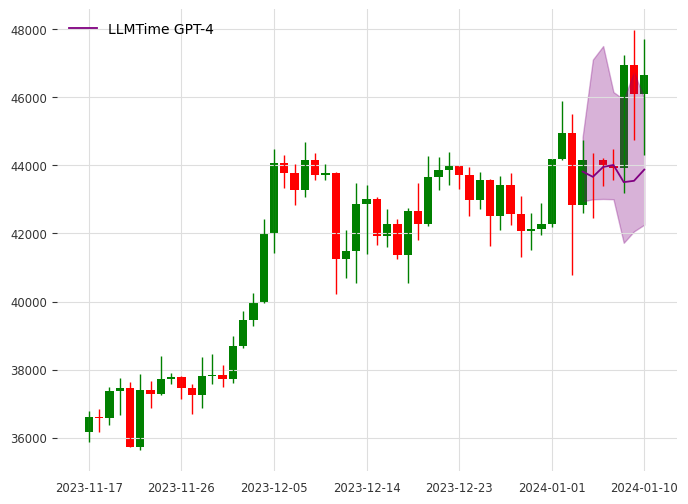

Data set : BTC_Daily_ohlc
from 2023-09-30 to 2023-01-01
training on 96 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]

pred dict {'samples': date  2024-01-04 09:00:00  2024-01-05 09:00:00  2024-01-06 09:00:00  \
0            42952.261819         43366.093326         43779.924833   
1            42952.261819         42400.486477         43814.410792   
2            42745.346066         43366.093326         43848.896751   
3            43055.719696         42952.261819         43435.065244   
4            43641.980997         44021.326545         44262.728258   
5            43090.205655         45090.391272         45055.905313   
6            43435.065244         43607.495039         44435.158052   
7            43779.924833         44331.700176         44193.756340   
8            43090.205655         43021.233737         42434.972436   
9            42952.261819         43710.952915         44297.214217   

date  2024-01-07 09:00:00  2024-01-08 09:00:00  2024-01-09 09:00:00  \
0            44090.298463         45297.307025         45573.194696   
1            44538.615929         44400.672093        

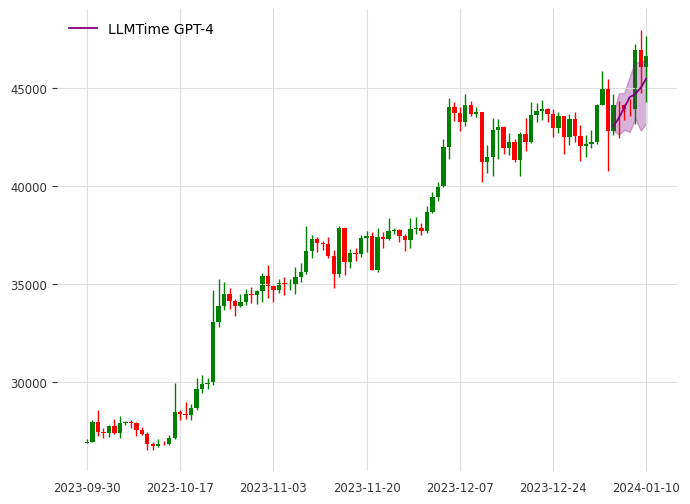

Data set : BTC_Daily_ohlc
from 2023-06-26 to 2023-01-01
training on 192 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


pred dict {'samples': date  2024-01-04 09:00:00  2024-01-05 09:00:00  2024-01-06 09:00:00  \
0            42956.808753         43375.899570         43822.929775   
1            42900.929977         42789.172426         42677.414875   
2            42705.354263         42817.111814         42928.869365   
3            42900.929977         43236.202631         43850.869163   
4            44716.990185         44772.868960         44661.111409   
5            44856.687124         44996.384063         44493.475082   
6            42956.808753         43068.566304         43208.263243   
7            42928.869365         43180.323855         43655.293448   
8            43012.687529         43096.505692         42984.748141   
9            43850.869163         44577.293246         44493.475082   

date  2024-01-07 09:00:00  2024-01-08 09:00:00  2024-01-09 09:00:00  \
0            43683.232836         43906.747938         43990.566102   
1            42761.233038         42817.111814        

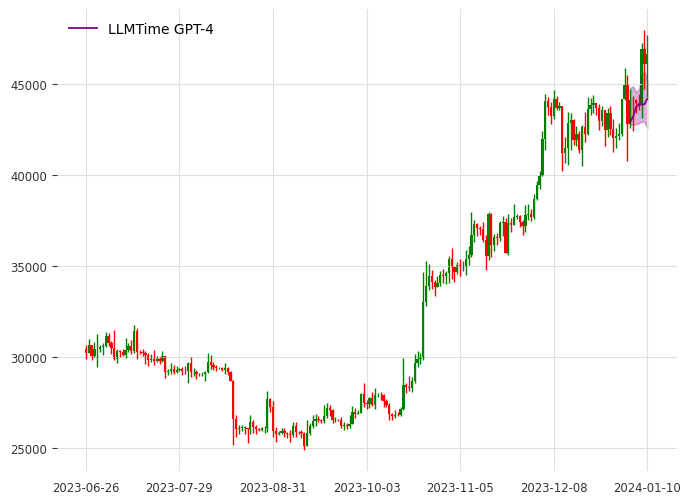

Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only
The path for the pickle file are the following : 
pickle/dic_error_classic_2024-01-11_median.pkl
Data set : BTC_Daily_ohlc
from 2024-01-04 to 2023-01-01
training on 6 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

pred dict {'samples': date  2024-01-10 09:00:00  2024-01-11 09:00:00  2024-01-12 09:00:00  \
0            46944.557738         46107.442208         46107.442208   
1            46944.557738         46107.442208         46107.442208   
2            46944.557738         46107.442208         46107.442208   
3            46944.557738         46107.442208         46107.442208   
4            46944.557738         46107.442208         50160.843721   
5            46944.557738         46107.442208         46107.442208   
6            46944.557738         46107.442208         46107.442208   
7            46944.557738         46107.442208         46107.442208   
8            46944.557738         46107.442208         46107.442208   
9            46944.557738         46107.442208         46107.442208   

date  2024-01-13 09:00:00  2024-01-14 09:00:00  2024-01-15 09:00:00  \
0            46107.442208         46107.442208         46107.442208   
1            46107.442208         46107.442208        

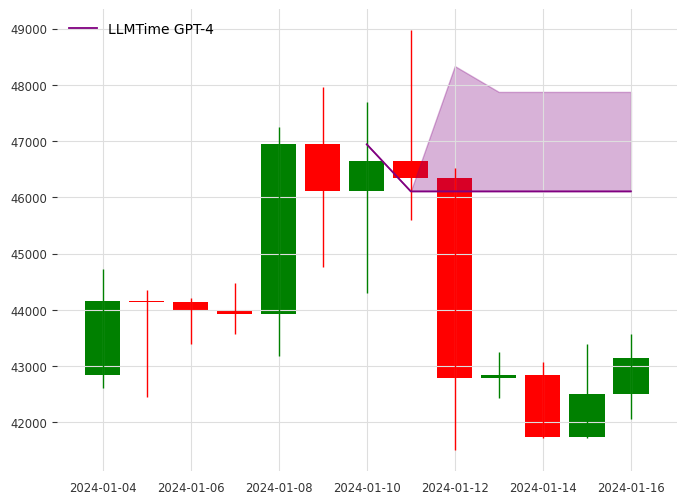

Data set : BTC_Daily_ohlc
from 2023-12-29 to 2023-01-01
training on 12 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]

pred dict {'samples': date  2024-01-10 09:00:00  2024-01-11 09:00:00  2024-01-12 09:00:00  \
0            45308.311687         45740.024995         45567.339672   
1            45480.997010         44919.769709         44531.227732   
2            46862.479596         47164.678912         46991.993588   
3            45783.196326         45740.024995         48762.018152   
4            46042.224310         45955.881649         45912.710318   
5            44315.371078         44056.343093         44229.028416   
6            44833.427048         45524.168341         45826.367656   
7            46258.080964         46430.766288         45912.710318   
8            44272.199747         45524.168341         45135.626363   
9            45653.682333         45351.483017         45480.997010   

date  2024-01-13 09:00:00  2024-01-14 09:00:00  2024-01-15 09:00:00  \
0            45524.168341         48546.161497         47725.906212   
1            44229.028416         44013.171762        

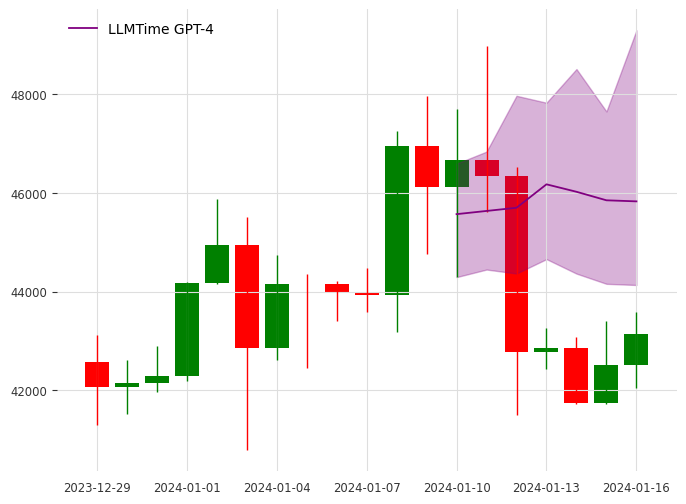

Data set : BTC_Daily_ohlc
from 2023-12-17 to 2023-01-01
training on 24 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

pred dict {'samples': date  2024-01-10 09:00:00  2024-01-11 09:00:00  2024-01-12 09:00:00  \
0            46337.200659         45740.126743         45356.293512   
1            45057.756554         45057.756554         45654.830470   
2            45953.367427         46507.793206         46763.682027   
3            44972.460280         44162.145681         45228.349101   
4            45697.478606         46337.200659         46550.441343   
5            46422.496932         47787.237311         48000.477995   
6            46081.311838         46294.552522         46294.552522   
7            46337.200659         46507.793206         47573.996627   
8            45526.886059         46507.793206         46166.608111   
9            46251.904385         46081.311838         46209.256248   

date  2024-01-13 09:00:00  2024-01-14 09:00:00  2024-01-15 09:00:00  \
0            44801.867733         44247.441954         44844.515870   
1            45654.830470         46678.385753        

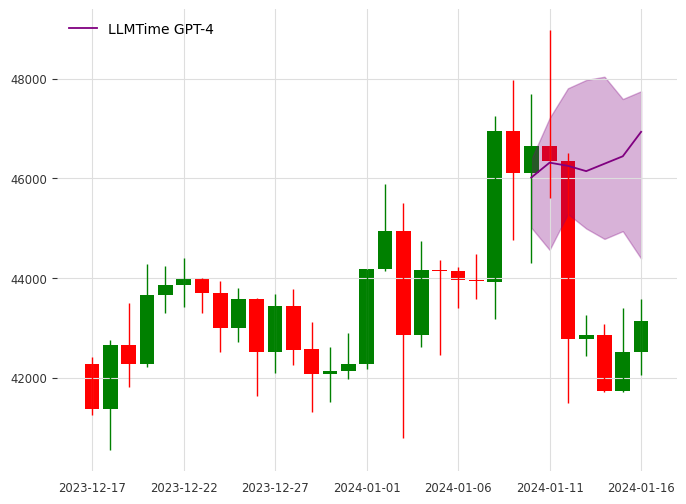

Data set : BTC_Daily_ohlc
from 2023-11-23 to 2023-01-01
training on 48 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


pred dict {'samples': date  2024-01-10 09:00:00  2024-01-11 09:00:00  2024-01-12 09:00:00  \
0            46244.004260         46453.727636         47502.344512   
1            46076.225560         44859.829983         44943.719333   
2            46160.114910         45782.612835         45824.557510   
3            45111.498033         44985.664008         44817.885308   
4            46160.114910         46202.059585         46495.672311   
5            46244.004260         47208.731787         47376.510487   
6            46160.114910         46327.893610         46621.506336   
7            46369.838285         45782.612835         46034.280885   
8            46160.114910         46327.893610         44817.885308   
9            46244.004260         46202.059585         45656.778809   

date  2024-01-13 09:00:00  2024-01-14 09:00:00  2024-01-15 09:00:00  \
0            46369.838285         46495.672311         47963.735938   
1            45069.553358         44943.719333        

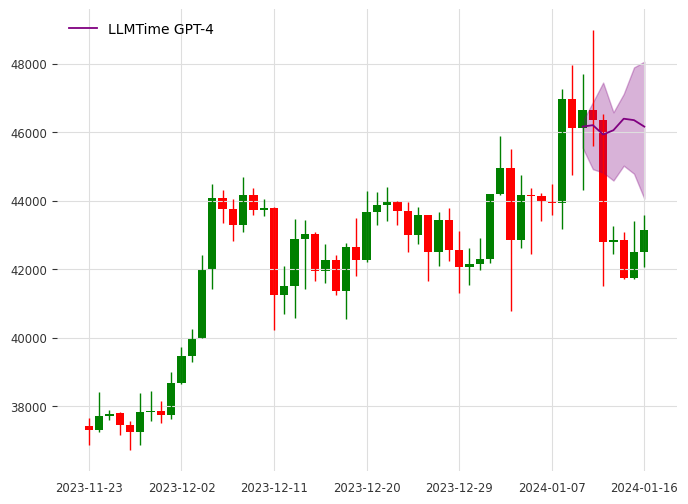

Data set : BTC_Daily_ohlc
from 2023-10-06 to 2023-01-01
training on 96 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

pred dict {'samples': date  2024-01-10 09:00:00  2024-01-11 09:00:00  2024-01-12 09:00:00  \
0            46676.708638         46536.590939         47272.208861   
1            46256.355540         45695.884742         45625.825892   
2            46081.208415         46396.473239         46641.679213   
3            46396.473239         46256.355540         46676.708638   
4            46186.296690         45906.061291         46991.973462   
5            46466.532089         45555.767042         46256.355540   
6            46571.620364         47027.002887         46851.855763   
7            46256.355540         46536.590939         46431.502664   
8            46536.590939         46676.708638         47132.091162   
9            47202.150011         47167.120586         46956.944037   

date  2024-01-13 09:00:00  2024-01-14 09:00:00  2024-01-15 09:00:00  \
0            48077.885633         48323.091607         48428.179882   
1            45765.943592         45976.120141        

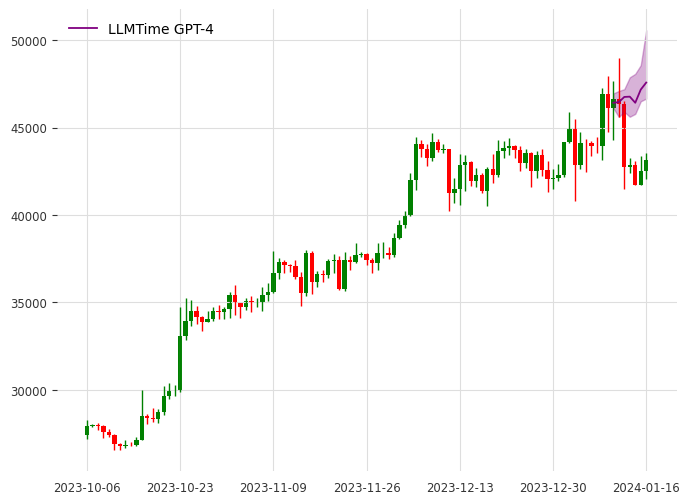

Data set : BTC_Daily_ohlc
from 2023-07-02 to 2023-01-01
training on 192 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.14s/it]

pred dict {'samples': date  2024-01-10 09:00:00  2024-01-11 09:00:00  2024-01-12 09:00:00  \
0            45862.505085         46365.414065         44661.111409   
1            45890.444473         45974.262636         45778.686921   
2            45666.929370         45583.111207         45387.535492   
3            45890.444473         46337.474678         47203.595700   
4            45890.444473         45694.868758         45024.323451   
5            45918.383860         45583.111207         45611.050595   
6            46113.959575         46253.656514         46393.353453   
7            46365.414065         46756.565495         46812.444270   
8            45834.565697         45611.050595         45387.535492   
9            45862.505085         45918.383860         46365.414065   

date  2024-01-13 09:00:00  2024-01-14 09:00:00  2024-01-15 09:00:00  \
0            44130.263041         43599.414672         43627.354060   
1            45555.171819         46141.898963        

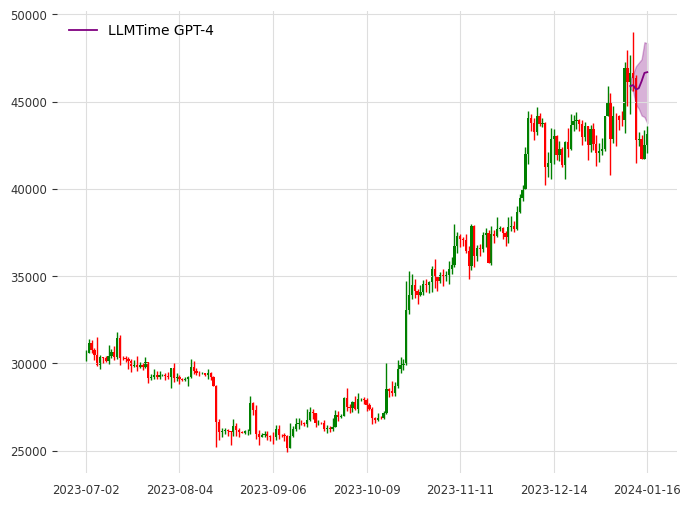

Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only
The path for the pickle file are the following : 
pickle/dic_error_classic_2024-01-17_median.pkl
Data set : BTC_Daily_ohlc
from 2024-01-10 to 2023-01-01
training on 6 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

pred dict {'samples': date  2024-01-16 09:00:00  2024-01-17 09:00:00  2024-01-18 09:00:00  \
0            42710.434375         43350.131345         43094.252557   
1            41388.393970         42156.030334         41047.222252   
2            42113.383869         41857.505081         41431.040434   
3            41942.798010         42198.676798         42198.676798   
4            42710.434375         43435.424274         43179.545486   
5            42283.969728         41985.444475         41985.444475   
6            42369.262657         42283.969728         42283.969728   
7            42028.090940         42411.909122         42411.909122   
8            42881.020233         43008.959627         43520.717203   
9            41900.151546         43008.959627         43008.959627   

date  2024-01-19 09:00:00  2024-01-20 09:00:00  2024-01-21 09:00:00  \
0            43733.949527         43733.949527         43733.949527   
1            41814.858616         40706.050535        

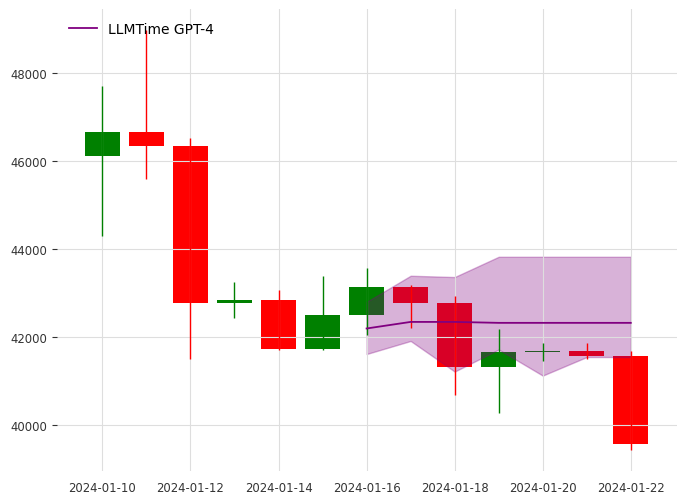

Data set : BTC_Daily_ohlc
from 2024-01-04 to 2023-01-01
training on 12 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

pred dict {'samples': date  2024-01-16 09:00:00  2024-01-17 09:00:00  2024-01-18 09:00:00  \
0            41553.548370         42330.653690         41208.168227   
1            43539.484188         44316.589508         43625.829223   
2            41294.513263         41639.893405         40949.133121   
3            42719.206350         43323.621599         43409.966634   
4            42071.618583         41726.238441         42416.998725   
5            42157.963619         42330.653690         41985.273547   
6            42028.446065         42935.068939         41596.720887   
7            41639.893405         41812.583476         41510.375852   
8            43280.449081         43064.586492         44100.726919   
9            41164.995709         41251.340745         40128.855283   

date  2024-01-19 09:00:00  2024-01-20 09:00:00  2024-01-21 09:00:00  \
0            41985.273547         40862.788085         41639.893405   
1            44402.934543         43712.174259        

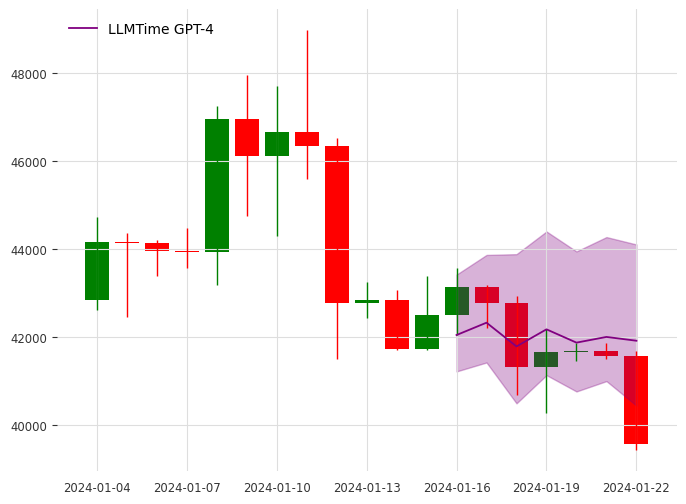

Data set : BTC_Daily_ohlc
from 2023-12-23 to 2023-01-01
training on 24 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

pred dict {'samples': date  2024-01-16 09:00:00  2024-01-17 09:00:00  2024-01-18 09:00:00  \
0            43551.737379         42824.806073         41926.832107   
1            43594.498044         43124.130729         41841.310776   
2            42696.524078         41713.028781         42354.438757   
3            41755.789446         40772.294149         42012.353437   
4            42012.353437         43209.652059         42995.848733   
5            42910.327403         44193.147356         44492.472011   
6            43166.891394         43337.934054         42268.917427   
7            43680.019375         42953.088068         43551.737379   
8            42867.566738         43295.173389         42739.284743   
9            43423.455384         43722.780040         44834.557332   

date  2024-01-19 09:00:00  2024-01-20 09:00:00  2024-01-21 09:00:00  \
0            42439.960087         42696.524078         44064.865360   
1            42611.002748         43423.455384        

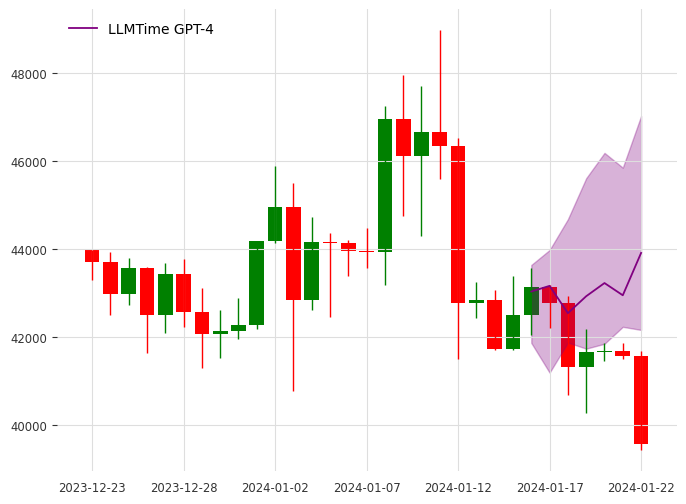

Data set : BTC_Daily_ohlc
from 2023-11-29 to 2023-01-01
training on 48 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

pred dict {'samples': date  2024-01-16 09:00:00  2024-01-17 09:00:00  2024-01-18 09:00:00  \
0            42425.617788         42256.507204         42383.340142   
1            42594.728372         42679.283664         43144.337771   
2            42425.617788         41368.676637         41495.509576   
3            42383.340142         42045.118974         42637.006018   
4            43355.726001         43271.170709         42932.949540   
5            42679.283664         43186.615417         42932.949540   
6            41241.843699         42763.838956         43355.726001   
7            42848.394248         42510.173080         41876.008390   
8            42467.895434         42341.062496         41833.730744   
9            42594.728372         41410.954283         41833.730744   

date  2024-01-19 09:00:00  2024-01-20 09:00:00  2024-01-21 09:00:00  \
0            42341.062496         41580.064868         42129.674266   
1            43271.170709         43059.782479        

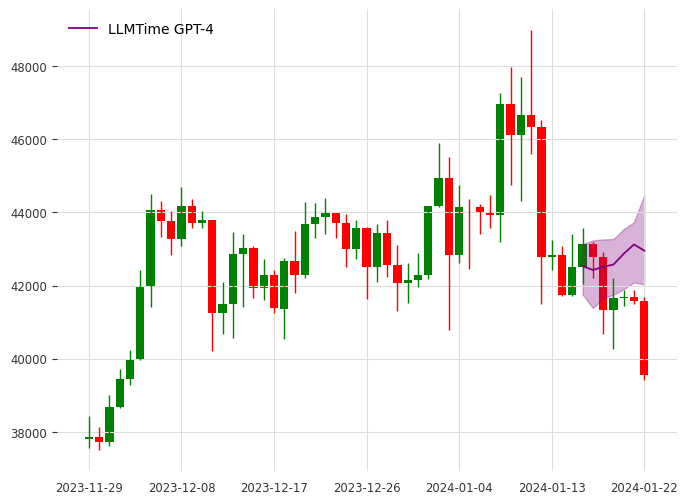

Data set : BTC_Daily_ohlc
from 2023-10-12 to 2023-01-01
training on 96 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


pred dict {'samples': date  2024-01-16 09:00:00  2024-01-17 09:00:00  2024-01-18 09:00:00  \
0            42588.750511         42909.905731         43587.900083   
1            42981.273557         42945.589644         43302.428777   
2            42909.905731         43016.957471         44265.894436   
3            42303.279205         42374.647031         42553.066598   
4            42481.698771         43266.744864         43837.687476   
5            42909.905731         43266.744864         43195.377037   
6            42945.589644         41768.020505         42231.911378   
7            41803.704419         42481.698771         42410.330945   
8            42196.227465         41625.284852         42160.543552   
9            42874.221817         42695.802251         43480.848343   

date  2024-01-19 09:00:00  2024-01-20 09:00:00  2024-01-21 09:00:00  \
0            43837.687476         43802.003563         43980.423129   
1            43552.216170         43873.371389        

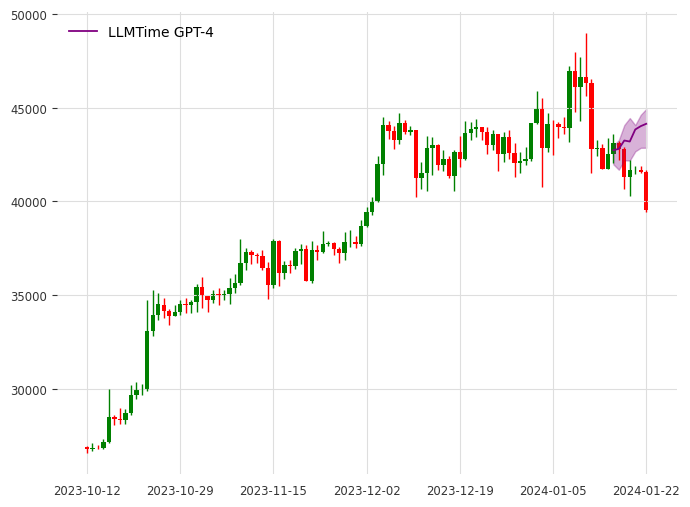

Data set : BTC_Daily_ohlc
from 2023-07-08 to 2023-01-01
training on 192 and forecasting on 7 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


pred dict {'samples': date  2024-01-16 09:00:00  2024-01-17 09:00:00  2024-01-18 09:00:00  \
0            42398.020997         41923.051404         42006.869567   
1            42006.869567         41252.506097         40945.172831   
2            41392.203036         41336.324260         41755.415077   
3            42398.020997         42062.748343         42286.263446   
4            42481.839160         42509.778548         43096.505692   
5            42537.717936         42705.354263         42649.475487   
6            42509.778548         42817.111814         42789.172426   
7            42342.142221         42230.384670         42537.717936   
8            42649.475487         42649.475487         43068.566304   
9            42062.748343         42649.475487         43375.899570   

date  2024-01-19 09:00:00  2024-01-20 09:00:00  2024-01-21 09:00:00  \
0            41895.112016         41699.536302         41280.445485   
1            42174.505894         42146.566507        

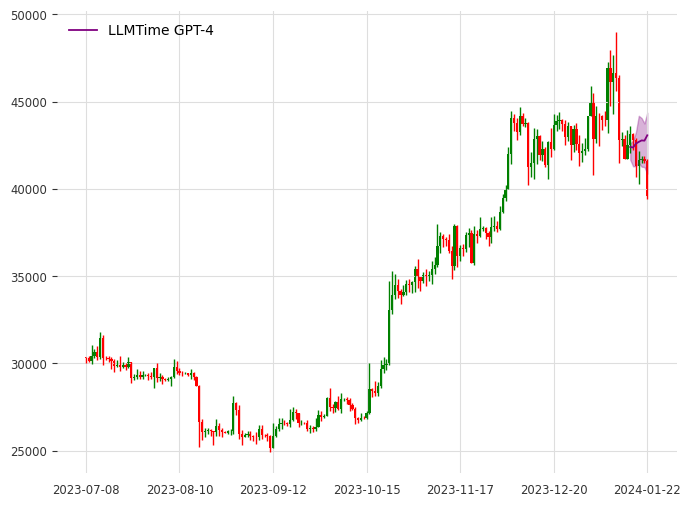

Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only
The path for the pickle file are the following : 
pickle/dic_error_classic_2024-01-23_median.pkl


In [13]:
# datasets = get_bitcoin_datasets(predict_steps=30, start_date="2024-02-01")
# ds_name = 'BTC_BitHourly'
list_date = ["2023-11-30", "2023-12-06", "2023-12-12", "2023-12-18", "2023-12-24", "2023-12-30", "2024-01-05", "2024-01-11", "2024-01-17", "2024-01-23"]
for starting_date in list_date :
    index = 0

    dic_error_median = {"input_length" : {6: {"Mae": None, "Mse": None},
                                12: {"Mae": None, "Mse": None},
                                24: {"Mae": None, "Mse": None},
                                48: {"Mae": None, "Mse": None},
                                96: {"Mae": None, "Mse": None},
                                192: {"Mae": None, "Mse": None}}}

    dic_predict = {"input_length" : {6: {"Mae": None, "Mse": None},
                                12: {"Mae": None, "Mse": None},
                                24: {"Mae": None, "Mse": None},
                                48: {"Mae": None, "Mse": None},
                                96: {"Mae": None, "Mse": None},
                                192: {"Mae": None, "Mse": None}}}

    predict_step = 7 
    for input_length in [6, 12, 24, 48, 96, 192] :

        train, test, df = get_bitcoin_datasets(input_length, predict_length = predict_step, end_date = starting_date)
        ds_name = 'BTC_Daily_ohlc'

        out = {}

        for i,model in enumerate(model_names): # GPT-4 takes a about a minute to run
            model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
            hypers = list(grid_iter(model_hypers[model]))
            num_samples = 10
            pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
            print("pred dict",  pred_dict)
            print("Type du dictionnaire :", type(pred_dict))
            print("here is the type", type(pred_dict['samples']))

            list_of_lists = pred_dict['samples'].values.tolist()
            print("list of lists : ",list_of_lists)

            
            targets = np.array(test)
            medians = pred_dict['median']
            print("targets", targets)
            print("median", medians)
            medians = medians.values

            mae = np.mean(np.abs(medians - test)) # (num_series)
            mse = np.mean(np.square(medians - test))
            pred_dict['maes'] = mse
            pred_dict['mae'] = mae

            out[model] = pred_dict

            print("Raw list completion :")
            print(pred_dict["completions_list"])

            print("Model : ", model)
            print("MAE : ", pred_dict['mae'])
            print("MAES : ", pred_dict['maes']) 

            dic_error_median["input_length"][input_length]["Mae"] = pred_dict['mae']
            dic_error_median["input_length"][input_length]["Mse"] = pred_dict['maes']
            print("dic_error_median : ",dic_error_median)

            dic_predict["input_length"][input_length]["Mae"] = list_of_lists



            string = out[model]['input_strs']
            string = str(string)
            number_comma = 0
            for elt in string :
                # print(elt)
                if elt == ',' :
                    number_comma += 1
            print("Sequence lenght : ", number_comma - 1)
            print("Raw scaled sequence")
            print(string)

            index_save = input_length
            current_folder =  starting_date + "_" + str(index_save)
            plot_preds_candles(df ,train, test, pred_dict, model, show_samples=False, save_index=current_folder)
        
        
    dic_name_median =  "pickle/dic_error_" + "classic" + "_" + starting_date + "_median" + ".pkl"
    dic_name_predict = "pickle/dic_error_" + "classic" + "_" + starting_date + ".pkl"

    with open(dic_name_median, 'wb') as fichier:
        pickle.dump(dic_error_median, fichier)

    with open(dic_name_predict, 'wb') as fichier:
        pickle.dump(dic_predict, fichier)

    print("Two pickle files have been created one with MSE/MAE among all samples and the second with MSE/MAE among median only")
    print(f"The path for the pickle file are the following : ")
    print(dic_name_median)


        


In [14]:
list_date = ["2023-11-30", "2023-12-06", "2023-12-12", "2023-12-18", "2023-12-24", "2023-12-30", "2024-01-05", "2024-01-11", "2024-01-17", "2024-01-23"]

dic_error_7_median ={"input_length" : {6: {"Mae": [], "Mse": []},
                                12: {"Mae": [], "Mse": []},
                                24: {"Mae": [], "Mse": []},
                                48: {"Mae": [], "Mse": []},
                                96: {"Mae": [], "Mse": []},
                                192: {"Mae": [], "Mse": []}}}
prediction = []

for elt_date in list_date :
    path = "pickle/dic_error_classic_" + elt_date +".pkl"
    with open(path, 'rb') as fichier:
        dic_error = pickle.load(fichier)

    
    for elt in dic_error_7_median["input_length"].items() :
        print("elt :", elt[0])
        if elt[0] != 192 :
            continue
        list = dic_error["input_length"][elt[0]]["Mae"]
        print("list : ",list)
        prediction.append(list)
        sub_list_7 = []
        for sub_elt in list :
            print("sub_elt : ", sub_elt)
            sub_list_7.append(np.mean(sub_elt))
        dic_error_7_median["input_length"][elt[0]]["Mae"].append(np.mean(sub_list_7))

    
# for elt in dic_error_7_median["input_length"].items() :
#     inter = dic_error_7_median["input_length"][elt[0]]["Mae"] 
#     inter = np.mean(inter)
#     dic_error_7_median["input_length"][elt[0]]["Mae"] = inter

elt : 6
elt : 12
elt : 24
elt : 48
elt : 96
elt : 192
list :  [[37384.9261982542, 37062.98926651466, 36687.3961794852, 36445.943480680544, 36606.91194655031, 36338.6311701007, 36553.255791260395], [37304.441965319325, 37358.09812060924, 37706.86312999375, 38431.22122640771, 38189.76852760306, 38592.18969227748, 38484.87738169764], [37331.27004296428, 37411.75427589917, 37653.206974703826, 38270.252760537944, 38377.565071117795, 38565.36161463252, 38672.67392521237], [37223.957732384435, 37304.441965319325, 37250.785810029396, 36633.74002419528, 36687.3961794852, 36419.11540303558, 37116.645421804584], [37170.30157709451, 37331.27004296428, 37170.30157709451, 37197.129654739474, 36982.50503357978, 37089.81734415963, 37948.315828798404], [37277.61388767436, 35855.72577249138, 34621.634200823144, 35560.6169183968, 35748.413461911536, 35641.10115133169, 36124.006548941004], [37089.81734415963, 37009.33311122474, 37438.58235354413, 37304.441965319325, 37384.9261982542, 37143.473499449545, 3

end date : 2024-01-23
start date :  2023-11-23
[[[37384.9261982542, 37062.98926651466, 36687.3961794852, 36445.943480680544, 36606.91194655031, 36338.6311701007, 36553.255791260395], [37304.441965319325, 37358.09812060924, 37706.86312999375, 38431.22122640771, 38189.76852760306, 38592.18969227748, 38484.87738169764], [37331.27004296428, 37411.75427589917, 37653.206974703826, 38270.252760537944, 38377.565071117795, 38565.36161463252, 38672.67392521237], [37223.957732384435, 37304.441965319325, 37250.785810029396, 36633.74002419528, 36687.3961794852, 36419.11540303558, 37116.645421804584], [37170.30157709451, 37331.27004296428, 37170.30157709451, 37197.129654739474, 36982.50503357978, 37089.81734415963, 37948.315828798404], [37277.61388767436, 35855.72577249138, 34621.634200823144, 35560.6169183968, 35748.413461911536, 35641.10115133169, 36124.006548941004], [37089.81734415963, 37009.33311122474, 37438.58235354413, 37304.441965319325, 37384.9261982542, 37143.473499449545, 37197.129654739

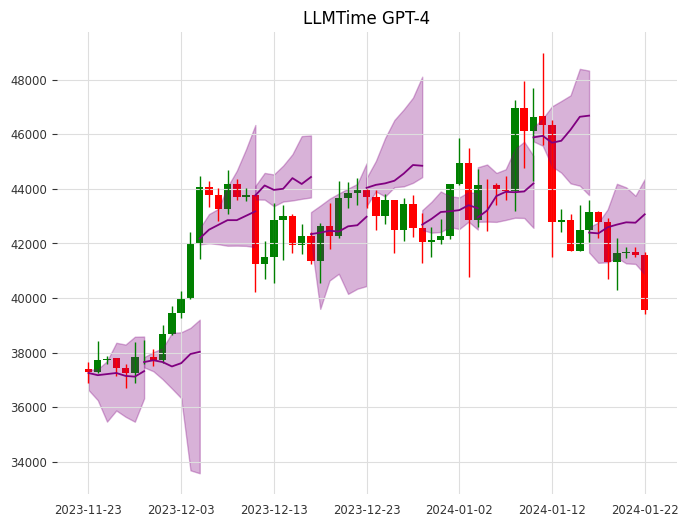

In [18]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

def get_data_set(name, input_length, start_date, end_date) :
    with open(name) as f:
        df = pd.read_csv(f, usecols=[0, 4], parse_dates=[0])
        mask = (df["date"] >= start_date) & (df["date"] <= end_date)
        df = df.loc[mask]
        df['close'] = df['close'].astype(float)
        series = pd.Series(df['close'].values, index=df['date'])

        f.seek(0)
        df_raw = pd.read_csv(f, parse_dates=[0])
        df_raw = df_raw.loc[mask]

        splitpoint = input_length
        train = series.iloc[:splitpoint]
        test = series.iloc[splitpoint:]

    return (df_raw, train)


def convert_date_good(input_length, end_date, predict_last_date) :
    ending_predict_date_num = datetime.strptime(end_date, '%Y-%m-%d')
    new_date = ending_predict_date_num - timedelta(days=input_length) - timedelta(days=predict_last_date)
    start_date = new_date.strftime('%Y-%m-%d')
    print("end date :", end_date)
    print("start date : ", start_date)
    return start_date

end_date = "2024-01-23"
input_length = 61
start_date = convert_date_good(input_length, end_date, 0)
print(prediction)

df_raw, train = get_data_set("datasets/bitcoin/BTC_Daily_ohlc.csv", input_length, start_date, end_date)

plot_preds_candles_maxi(df_raw, train, prediction, model_name="LLMTime GPT-4", savefig = "test_2_month_data")

In [4]:
list_date = ["2023-11-30", "2023-12-06", "2023-12-12", "2023-12-18", "2023-12-24", "2023-12-30", "2024-01-05", "2024-01-11", "2024-01-17", "2024-01-23"]
dic_error_7_median =      {"input_length" : {6: {"Mae": [], "Mse": []},
                                12: {"Mae": [], "Mse": []},
                                24: {"Mae": [], "Mse": []},
                                48: {"Mae": [], "Mse": []},
                                96: {"Mae": [], "Mse": []},
                                192: {"Mae": [], "Mse": []}}}
for elt_date in list_date :
    path = "pickle/dic_error_classic_" + elt_date + "_median.pkl"
    with open(path, 'rb') as fichier:
        dic_error = pickle.load(fichier)

    for elt in dic_error_7_median["input_length"].items() :
        list = dic_error["input_length"][elt[0]]["Mae"]
        dic_error_7_median["input_length"][elt[0]]["Mae"].append(np.mean(list))
    
for elt in dic_error_7_median["input_length"].items() :
    inter = dic_error_7_median["input_length"][elt[0]]["Mae"] 
    inter = np.mean(inter)
    dic_error_7_median["input_length"][elt[0]]["Mae"] = inter

In [5]:
def table_display (dic_error_number) :
    table = []
    for key, value in dic_error_number['input_length'].items():
        row = [key, value['Mae'], value['Mse']]
        table.append(row)

    # En-tête du tableau
    headers = ['input_length', 'Mae', 'Mse']

    # Affichage du tableau
    print(tabulate(table, headers=headers))

print(dic_error_7_median)
table_display(dic_error_7_median)

{'input_length': {6: {'Mae': 1815.624991274263, 'Mse': []}, 12: {'Mae': 1848.960162027241, 'Mse': []}, 24: {'Mae': 1895.3413277136665, 'Mse': []}, 48: {'Mae': 1589.1111483578404, 'Mse': []}, 96: {'Mae': 1556.5938587056062, 'Mse': []}, 192: {'Mae': 1442.823415242441, 'Mse': []}}}
  input_length      Mae  Mse
--------------  -------  -----
             6  1815.62  []
            12  1848.96  []
            24  1895.34  []
            48  1589.11  []
            96  1556.59  []
           192  1442.82  []


In [20]:
with open("pickle/dic_error_classic_median.pkl", 'rb') as fichier:
        dict_error_median = pickle.load(fichier)


print(dic_error_median)

def display_tab (dic_error_number) :
    table = []
    for key, value in dic_error_number['input_length'].items():
        row = [key, value['Mae'], value['Mse']]
        table.append(row)

    # En-tête du tableau
    headers = ['input_length', 'Mae', 'Mse']

    # Affichage du tableau
    print(tabulate(table, headers=headers))

display_tab(dic_error_median)

{'input_length': {6: {'Mae': 3184.2164379947885, 'Mse': 13087684.392711189}, 12: {'Mae': 2373.3541898942835, 'Mse': 7999141.078329499}, 24: {'Mae': 2456.0923911928185, 'Mse': 8344978.4205345}, 48: {'Mae': 973.7839969497093, 'Mse': 1144665.4129625}, 96: {'Mae': 325.80371064508137, 'Mse': 129955.77830199001}, 192: {'Mae': 813.1084146194532, 'Mse': 764574.6859048309}}}
  input_length       Mae               Mse
--------------  --------  ----------------
             6  3184.22        1.30877e+07
            12  2373.35        7.99914e+06
            24  2456.09        8.34498e+06
            48   973.784       1.14467e+06
            96   325.804  129956
           192   813.108  764575


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


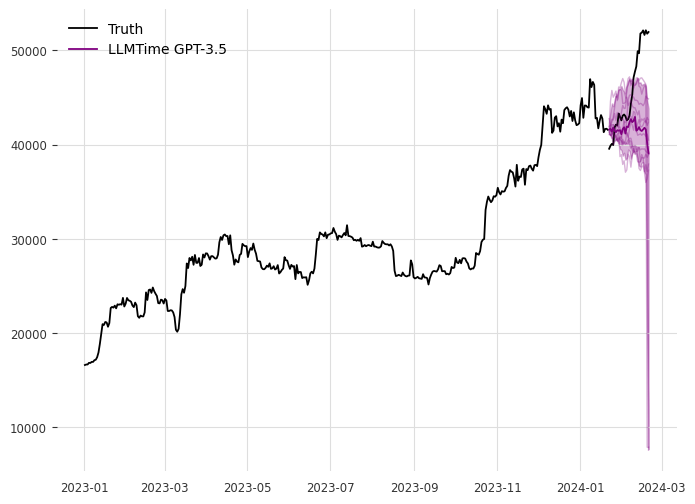

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.18s/it]

<Figure size 640x480 with 0 Axes>

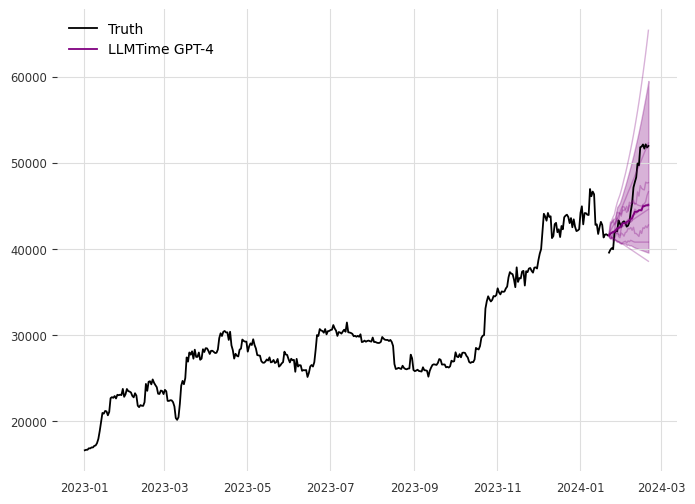

Model :  LLMTime GPT-3.5
Sequence lenght :  386
(' 2 5 2 , 2 5 4 , 2 5 4 , 2 5 9 , 2 5 8 , 2 6 1 , 2 6 1 , 2 6 6 , 2 6 8 , 2 7 5 , 2 8 9 , 3 1 4 , 3 4 4 , 3 7 3 , 3 7 0 , 3 7 9 , 3 7 8 , 3 6 5 , 3 7 6 , 4 2 0 , 4 2 3 , 4 2 1 , 4 2 7 , 4 1 9 , 4 3 1 , 4 3 0 , 4 3 1 , 4 3 0 , 4 5 0 , 4 2 4 , 4 3 3 , 4 5 0 , 4 4 3 , 4 4 1 , 4 3 8 , 4 2 7 , 4 2 3 , 4 3 6 , 4 2 8 , 3 9 6 , 3 9 1 , 3 9 8 , 3 9 6 , 3 9 5 , 4 0 7 , 4 6 6 , 4 4 4 , 4 7 3 , 4 7 5 , 4 6 5 , 4 8 0 , 4 7 0 , 4 6 2 , 4 5 5 , 4 3 4 , 4 3 4 , 4 4 5 , 4 4 3 , 4 3 3 , 4 4 7 , 4 4 2 , 4 1 1 , 4 1 1 , 4 1 4 , 4 1 3 , 4 0 7 , 3 9 3 , 3 5 6 , 3 5 0 , 3 5 9 , 4 0 2 , 4 6 0 , 4 7 6 , 4 6 5 , 4 8 5 , 5 5 1 , 5 3 8 , 5 6 7 , 5 6 0 , 5 7 1 , 5 4 7 , 5 7 6 , 5 5 3 , 5 5 3 , 5 6 7 , 5 4 4 , 5 4 8 , 5 7 8 , 5 6 9 , 5 8 1 , 5 8 1 , 5 7 3 , 5 6 3 , 5 7 3 , 5 7 3 , 5 6 9 , 5 6 6 , 5 6 6 , 5 7 7 , 6 1 4 , 6 2 9 , 6 2 1 , 6 3 4 , 6 3 7 , 6 3 2 , 6 3 2 , 6 0 8 , 6 3 4 , 5 9 0 , 5 7 5 , 5 4 8 , 5 6 3 , 5 5 7 , 5 5 5 , 5 7 6 , 5 8 0 , 6 0 9 , 6 0 5 , 6 0 2

100%|██████████| 1/1 [00:14<00:00, 14.16s/it]

<Figure size 640x480 with 0 Axes>

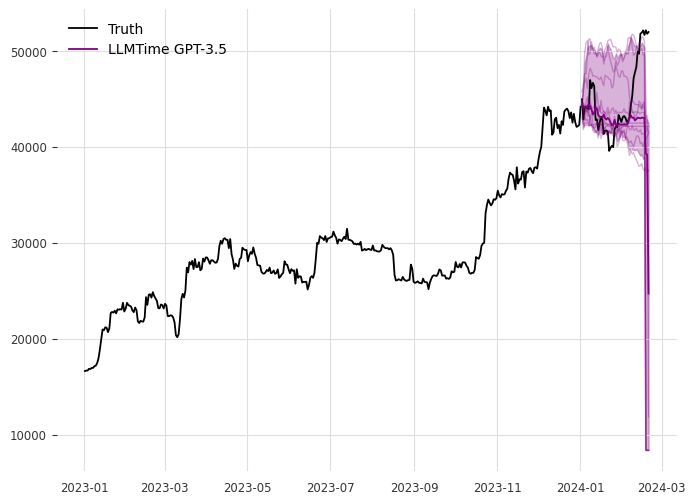

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:09<00:00,  9.30s/it]

<Figure size 640x480 with 0 Axes>

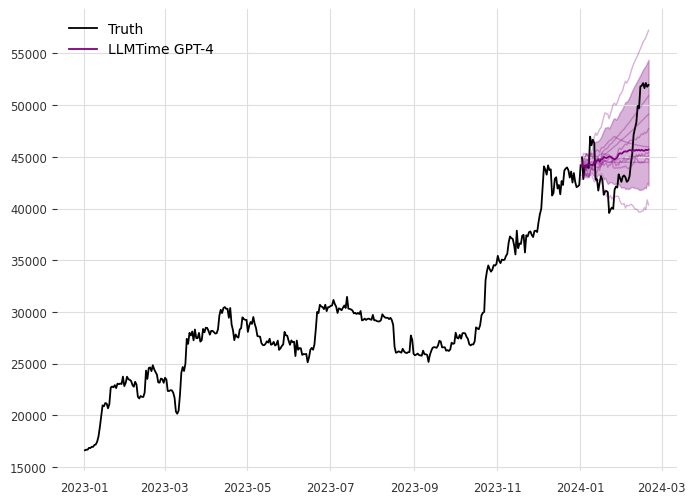

Model :  LLMTime GPT-3.5
Sequence lenght :  366
(' 2 4 2 , 2 4 4 , 2 4 4 , 2 4 9 , 2 4 8 , 2 5 2 , 2 5 2 , 2 5 7 , 2 5 8 , 2 6 6 , 2 8 1 , 3 0 7 , 3 3 9 , 3 6 9 , 3 6 7 , 3 7 6 , 3 7 4 , 3 6 1 , 3 7 3 , 4 1 9 , 4 2 3 , 4 2 1 , 4 2 7 , 4 1 8 , 4 3 1 , 4 2 9 , 4 3 1 , 4 3 0 , 4 5 1 , 4 2 4 , 4 3 3 , 4 5 1 , 4 4 3 , 4 4 2 , 4 3 9 , 4 2 7 , 4 2 2 , 4 3 6 , 4 2 8 , 3 9 4 , 3 8 9 , 3 9 6 , 3 9 3 , 3 9 3 , 4 0 6 , 4 6 8 , 4 4 4 , 4 7 5 , 4 7 7 , 4 6 6 , 4 8 3 , 4 7 2 , 4 6 4 , 4 5 7 , 4 3 5 , 4 3 4 , 4 4 5 , 4 4 4 , 4 3 3 , 4 4 8 , 4 4 3 , 4 1 0 , 4 1 0 , 4 1 2 , 4 1 2 , 4 0 6 , 3 9 1 , 3 5 2 , 3 4 6 , 3 5 5 , 4 0 0 , 4 6 2 , 4 7 8 , 4 6 7 , 4 8 8 , 5 5 8 , 5 4 4 , 5 7 5 , 5 6 7 , 5 7 9 , 5 5 4 , 5 8 4 , 5 6 0 , 5 6 0 , 5 7 5 , 5 5 0 , 5 5 4 , 5 8 6 , 5 7 7 , 5 8 9 , 5 8 9 , 5 8 1 , 5 7 0 , 5 8 1 , 5 8 1 , 5 7 7 , 5 7 3 , 5 7 4 , 5 8 5 , 6 2 4 , 6 4 0 , 6 3 1 , 6 4 5 , 6 4 8 , 6 4 3 , 6 4 3 , 6 1 8 , 6 4 6 , 5 9 9 , 5 8 3 , 5 5 4 , 5 7 0 , 5 6 4 , 5 6 1 , 5 8 5 , 5 8 8 , 6 1 9 , 6 1 4 , 6 1 2

100%|██████████| 1/1 [00:14<00:00, 14.53s/it]

<Figure size 640x480 with 0 Axes>

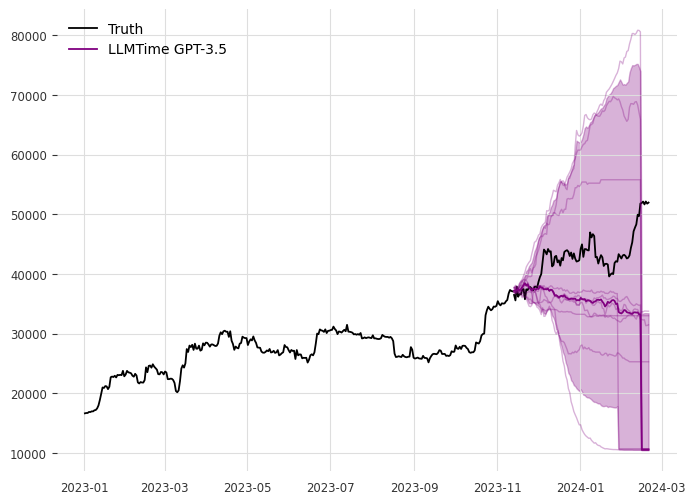

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:22<00:00, 22.34s/it]

<Figure size 640x480 with 0 Axes>

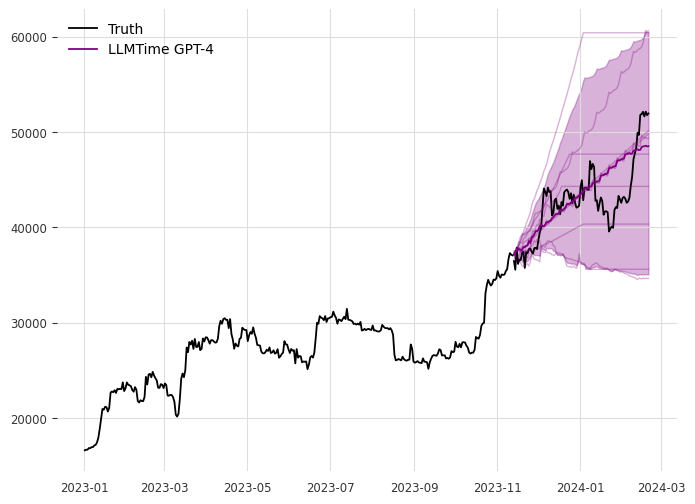

Model :  LLMTime GPT-3.5
Sequence lenght :  316
(' 2 6 0 , 2 6 2 , 2 6 2 , 2 7 0 , 2 6 9 , 2 7 4 , 2 7 4 , 2 8 1 , 2 8 4 , 2 9 5 , 3 1 6 , 3 5 4 , 3 9 9 , 4 4 2 , 4 3 9 , 4 5 2 , 4 5 0 , 4 3 0 , 4 4 7 , 5 1 4 , 5 1 9 , 5 1 6 , 5 2 4 , 5 1 3 , 5 3 1 , 5 2 8 , 5 3 1 , 5 2 9 , 5 5 9 , 5 2 1 , 5 3 3 , 5 5 9 , 5 4 8 , 5 4 6 , 5 4 2 , 5 2 5 , 5 1 8 , 5 3 8 , 5 2 6 , 4 7 7 , 4 7 0 , 4 8 0 , 4 7 7 , 4 7 6 , 4 9 4 , 5 8 4 , 5 5 0 , 5 9 4 , 5 9 6 , 5 8 1 , 6 0 5 , 5 8 9 , 5 7 8 , 5 6 7 , 5 3 6 , 5 3 5 , 5 5 1 , 5 4 9 , 5 3 4 , 5 5 4 , 5 4 7 , 5 0 1 , 5 0 1 , 5 0 4 , 5 0 3 , 4 9 4 , 4 7 4 , 4 1 7 , 4 0 8 , 4 2 1 , 4 8 6 , 5 7 5 , 5 9 8 , 5 8 2 , 6 1 2 , 7 1 2 , 6 9 2 , 7 3 7 , 7 2 6 , 7 4 2 , 7 0 6 , 7 5 0 , 7 1 5 , 7 1 5 , 7 3 7 , 7 0 1 , 7 0 7 , 7 5 2 , 7 3 9 , 7 5 7 , 7 5 7 , 7 4 5 , 7 2 9 , 7 4 5 , 7 4 5 , 7 3 9 , 7 3 4 , 7 3 5 , 7 5 1 , 8 0 7 , 8 3 0 , 8 1 7 , 8 3 8 , 8 4 1 , 8 3 4 , 8 3 5 , 7 9 8 , 8 3 8 , 7 7 1 , 7 4 8 , 7 0 7 , 7 3 0 , 7 2 1 , 7 1 7 , 7 5 0 , 7 5 5 , 8 0 0 , 7 9 3 , 7 9 0

<Figure size 640x480 with 0 Axes>

In [32]:
index = 0
for predict_step in [30,50,100] :
    starting_date = "2023-01-01"
    datasets = get_bitcoin_datasets(predict_steps=predict_step, start_date=starting_date)
    ds_name = 'BTC_Daily_ohlc'

    data = datasets[ds_name]
    train, test = data # or change to your own data
    out = {}
    for model in model_names: # GPT-4 takes a about a minute to run
        model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
        hypers = list(grid_iter(model_hypers[model]))
        num_samples = 10
        pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
        out[model] = pred_dict
        index += 1
        plot_preds(train, test, pred_dict, model, show_samples=True, save_index=index)


    for model in model_names[:-1]: # GPT-4 takes a about a minute to run
        print("Model : ", model)
        string = out[model]['input_strs']
        string = str(string)
        number_comma = 0
        for elt in string :
            # print(elt)
            if elt == ',' :
                number_comma += 1
        print("Sequence lenght : ", number_comma - 1)
        print(string)


    with open(f"datasets/bitcoin/BTC_Daily_ohlc.csv") as f:
        df = pd.read_csv(f, usecols=[0, 4], parse_dates=[0])
        mask = (df["date"] > starting_date) 
        df = df.loc[mask]

        start_date = df["date"].iloc[0]
        end_date = df["date"].iloc[-1]

        print("Data set : BTC_Daily_ohlc")
        print(f"from {start_date} to {end_date}")
        print(f"{df.shape[0]} data points, training on {df.shape[0]- predict_step} and forecasting on {predict_step} points")
        print("Imput is scaled closing price")

        # df['close'] = df['close'].astype(float)
        # series = pd.Series(df['close'].values, index=df['date'])


## Running LLMTime and Visualizing Results ##

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


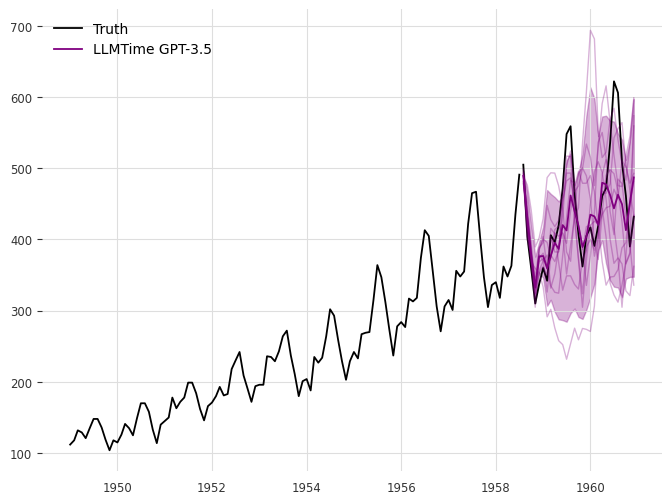

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.39s/it]


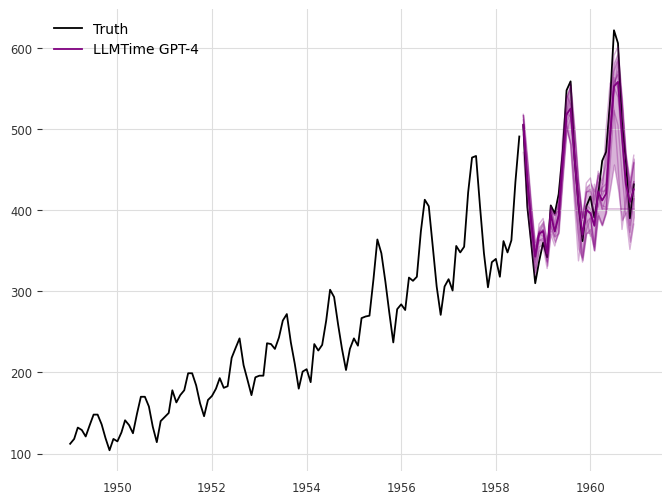

Train length: 86, Val length: 29


Hyperparameter search:   0%|          | 0/4 [00:00<?, ?it/s]/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization

Sampling with best hyper... defaultdict(<class 'dict'>, {'p': 12, 'd': 2, 'q': 0, 'dataset_name': 'AirPassengersDataset'}) 
 with NLL 3.747898


/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


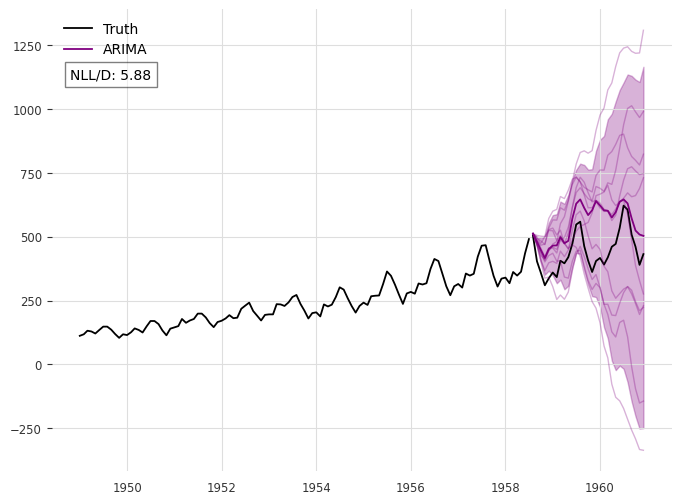

In [16]:
datasets = get_datasets()
ds_name = 'AirPassengersDataset'

data = datasets[ds_name]
train, test = data # or change to your own data
out = {}
for model in model_names: # GPT-4 takes a about a minute to run
    model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
    hypers = list(grid_iter(model_hypers[model]))
    num_samples = 10
    pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
    out[model] = pred_dict
    plot_preds(train, test, pred_dict, model, show_samples=True)